In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm._tqdm_notebook import tqdm_notebook
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.set_option("max_columns", 1000)
pd.set_option("max_rows", 200)

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [2]:
DIR = "/kaggle/input/lish-moa/"
train_feat = pd.read_csv(DIR+"train_features.csv")
test_feat = pd.read_csv(DIR+"test_features.csv")
train_nonscore = pd.read_csv(DIR+"train_targets_nonscored.csv")
train_score = pd.read_csv(DIR+"train_targets_scored.csv")
sub = pd.read_csv(DIR+"sample_submission.csv")

In [3]:
noncons_train_index = train_feat[train_feat.cp_type=="ctl_vehicle"].index
cons_train_index = train_feat[train_feat.cp_type!="ctl_vehicle"].index
noncons_test_index = test_feat[test_feat.cp_type=="ctl_vehicle"].index
cons_test_index = test_feat[test_feat.cp_type!="ctl_vehicle"].index

In [4]:
# remove ctl_vehicle data at first
train_feat = train_feat[train_feat.index.isin(cons_train_index)]
test_feat = test_feat[test_feat.index.isin(cons_test_index)]
train_nonscore = train_nonscore[train_nonscore.index.isin(cons_train_index)]
train_score = train_score[train_score.index.isin(cons_train_index)]

# overview

In [5]:
train_feat.shape

(21948, 876)

In [6]:
train_feat.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
0 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
1  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
2 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
3  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
4  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   

     g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
0 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360   
1  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646   
2 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181   
3 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580   
4  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685   

     g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30  \
0 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934   
1 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499   
2 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530   
3 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575   
4  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712   

     g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39  \
0 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
1 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
2  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
3  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
4  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

     g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48  \
0 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350   
1  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710   
2  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983   
3 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851   
4  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780   

     g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57  \
0  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263   
1 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759   
2  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621   
3  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331   
4 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130   

     g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66  \
0  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670   
1  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026   
2 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292   
3  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314   
4  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000   

     g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75  \
0 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332   
1  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857   
2  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570   
3  

In [7]:
set(train_feat.sig_id.unique()) == set(train_score.sig_id.unique())

True

In [8]:
set(test_feat.columns) == set(train_feat.columns)

True

In [9]:
train_feat.describe()

cp_time           g-0           g-1           g-2           g-3  \
count  21948.000000  21948.000000  21948.000000  21948.000000  21948.000000   
mean      48.015309      0.277675     -0.079845      0.168391      0.081265   
std       19.403896      1.427121      0.801954      1.035796      0.955117   
min       24.000000     -5.513000     -5.737000     -5.975000     -5.998000   
25%       24.000000     -0.460925     -0.534425     -0.425400     -0.429000   
50%       48.000000      0.000000     -0.034350      0.089950      0.003450   
75%       72.000000      0.533925      0.410450      0.679150      0.458450   
max       72.000000     10.000000      5.033000      8.257000     10.000000   

                g-4           g-5           g-6           g-7           g-8  \
count  21948.000000  21948.000000  21948.000000  21948.000000  21948.000000   
mean       0.084974     -0.143382      0.012126     -0.204332     -0.239865   
std        1.023297      1.183272      0.871004      1.136824      1.800194   
min       -6.369000    -10.000000    -10.000000    -10.000000    -10.000000   
25%       -0.438000     -0.607500     -0.509500     -0.501500     -0.546750   
50%       -0.013200     -0.017950     -0.028300     -0.006400     -0.021550   
75%        0.467525      0.504550      0.486950      0.407025      0.514300   
max       10.000000      7.282000      7.333000      5.473000      8.887000   

                g-9          g-10          g-11          g-12          g-13  \
count  21948.000000  21948.000000  21948.000000  21948.000000  21948.000000   
mean       0.104281     -0.133974      0.202817      0.107691      0.213532   
std        1.101453      1.313634      1.277898      1.231579      1.302843   
min       -8.337000    -10.000000     -5.870000     -8.587000     -5.018000   
25%       -0.368875     -0.502525     -0.480700     -0.464850     -0.491300   
50%        0.152250      0.045700      0.026050      0.037050      0.001850   
75%        0.687800      0.525450      0.595450      0.569025      0.575600   
max        6.433000     10.000000     10.000000     10.000000     10.000000   

               g-14          g-15          g-16          g-17          g-18  \
count  21948.000000  21948.000000  21948.000000  21948.000000  21948.000000   
mean      -0.190993     -0.018576      0.103618     -0.175805      0.098164   
std        1.270448      0.660990      1.445426      1.196896      0.752562   
min      -10.000000    -10.000000    -10.000000    -10.000000     -4.226000   
25%       -0.622425     -0.397300     -0.404850     -0.535075     -0.266500   
50%       -0.042150      0.001200      0.133950     -0.024250      0.006700   
75%        0.447550      0.385500      0.817325      0.468400      0.337200   
max       10.000000      4.134000      6.418000      4.750000      8.872000   

               g-19          g-20          g-21          g-22          g-23  \
count  21948.000000  21948.000000  21948.000000  21948.000000  21948.000000   
mean      -0.074091     -0.144396     -0.074853      0.072221     -0.115867   
std        0.843939      1.236532      0.805682      0.938032      0.759937   
min      -10.000000    -10.000000     -5.607000    -10.000000    -10.000000   
25%       -0.478950     -0.548025     -0.518425     -0.422700     -0.498100   
50%       -0.018600     -0.025700     -0.060900      0.002100      0.000000   
75%        0.406900      0.469700      0.413350      0.456850      0.325800   
max        4.081000      9.842000      5.248000      5.942000      5.201000   

               g-24          g-25          g-26          g-27          g-28  \
count  21948.000000  21948.000000  21948.000000  21948.000000  21948.000000   
mean      -0.127038     -0.077642     -0.135650      0.147021     -0.086897   
std        1.219883      0.873701      1.105230      0.992293      1.039058   
min      -10.000000     -8.272000     -8.184000     -4.835000     -7.913000   
25%       -0.531500     -0.515325     -0.547750     -0.42

In [10]:
test_feat.describe()

cp_time          g-0          g-1          g-2          g-3  \
count  3624.000000  3624.000000  3624.000000  3624.000000  3624.000000   
mean     48.019868     0.225962    -0.045640     0.148222     0.047238   
std      19.415234     1.415727     0.791498     1.054203     0.955675   
min      24.000000    -5.321000    -4.142000    -6.996000    -3.765000   
25%      24.000000    -0.491575    -0.529825    -0.415675    -0.464200   
50%      48.000000    -0.052300    -0.015650     0.081650    -0.043800   
75%      72.000000     0.462800     0.434100     0.645850     0.406025   
max      72.000000    10.000000     4.536000     8.227000    10.000000   

               g-4          g-5          g-6          g-7          g-8  \
count  3624.000000  3624.000000  3624.000000  3624.000000  3624.000000   
mean      0.084121    -0.157018    -0.018790    -0.165892    -0.224134   
std       0.988402     1.220558     0.845196     1.098616     1.716718   
min      -6.312000    -8.717000    -6.037000    -8.833000   -10.000000   
25%      -0.412450    -0.581150    -0.539800    -0.449325    -0.554800   
50%      -0.030100    -0.016450    -0.039500     0.012600    -0.037600   
75%       0.436575     0.506175     0.458175     0.416850     0.484050   
max       7.615000     6.356000     5.681000     2.736000     8.007000   

               g-9         g-10         g-11         g-12         g-13  \
count  3624.000000  3624.000000  3624.000000  3624.000000  3624.000000   
mean      0.130194    -0.123903     0.177419     0.087737     0.215700   
std       1.097803     1.326473     1.246094     1.194823     1.327154   
min      -7.799000    -9.283000    -7.908000    -6.223000    -3.784000   
25%      -0.329625    -0.469675    -0.499025    -0.481350    -0.498400   
50%       0.161950     0.061200    -0.012600     0.033700    -0.008850   
75%       0.716900     0.513125     0.581375     0.563825     0.547750   
max       5.348000     5.187000     8.320000     9.844000    10.000000   

              g-14         g-15         g-16         g-17         g-18  \
count  3624.000000  3624.000000  3624.000000  3624.000000  3624.000000   
mean     -0.186295    -0.011881     0.091610    -0.178185     0.075965   
std       1.180004     0.635764     1.415756     1.122189     0.713233   
min      -9.817000    -3.995000   -10.000000    -9.082000    -2.599000   
25%      -0.629875    -0.384250    -0.418475    -0.535475    -0.264975   
50%      -0.042300     0.005350     0.119500    -0.040000     0.000000   
75%       0.423700     0.401550     0.800050     0.410925     0.314250   
max       8.541000     2.872000     5.624000     3.600000     7.788000   

              g-19         g-20         g-21         g-22         g-23  \
count  3624.000000  3624.000000  3624.000000  3624.000000  3624.000000   
mean     -0.091501    -0.152250    -0.083564     0.006619    -0.110188   
std       0.811561     1.190436     0.784062     0.927115     0.758230   
min      -7.064000   -10.000000    -5.604000    -6.978000    -4.392000   
25%      -0.485025    -0.553100    -0.523650    -0.444725    -0.501300   
50%      -0.032750    -0.007000    -0.071150    -0.026700     0.000000   
75%       0.387875     0.449575     0.372425     0.422675     0.328500   
max       3.657000     6.833000     3.542000     4.697000     5.161000   

              g-24         g-25         g-26         g-27         g-28  \
count  3624.000000  3624.000000  3624.000000  3624.000000  3624.000000   
mean     -0.114811    -0.088764    -0.110922     0.192445    -0.101584   
std       1.212759     0.862824     1.097381     1.026325     1.061817   
min     -10.000000    -5.668000    -7.188000    -4.291000    -6.756000   
25%      -0.527450    -0.528950    -0.525800    -0.392550    -0.391900   
50%       0.020000    -0.046950    -0.012250     0.094700    -0.002750   
75%       0.517150     0.401425     0.488925     0.614250     0.380225   
max       7.374000     4.402000    10.000000    10.000000     6.089000   

         

In [11]:
# missing values
print(train_feat.isnull().sum().sum())
print(test_feat.isnull().sum().sum())
print(train_score.isnull().sum().sum())
print(train_nonscore.isnull().sum().sum())

0
0
0
0


# cp variables

In [12]:
cp_feats = [i for i in train_feat.columns if "cp_" in i]
print(cp_feats)

['cp_type', 'cp_time', 'cp_dose']


[24 72 48]
[24 72 48]


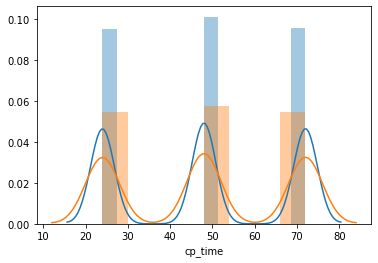

In [13]:
# cp_time: treatment duration
print(train_feat["cp_time"].unique())
print(test_feat["cp_time"].unique())
sns.distplot(train_feat["cp_time"])
sns.distplot(test_feat["cp_time"])

In [14]:
# cp_dose: dose (high or low)
print(train_feat["cp_dose"].value_counts())
print(train_feat["cp_dose"].value_counts(normalize=True))
print("#############")
print(test_feat["cp_dose"].value_counts())
print(test_feat["cp_dose"].value_counts(normalize=True))

D1    11196
D2    10752
Name: cp_dose, dtype: int64
D1    0.510115
D2    0.489885
Name: cp_dose, dtype: float64
#############
D1    1845
D2    1779
Name: cp_dose, dtype: int64
D1    0.509106
D2    0.490894
Name: cp_dose, dtype: float64


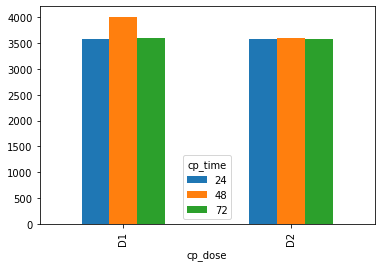

In [15]:
# interaction between cp variables 
pd.crosstab(train_feat["cp_dose"], train_feat["cp_time"]).plot(kind="bar")

# g variables

In [16]:
# clear colleration in g variables
g_feats = [i for i in train_feat.columns if "g-" in i]
correlations = train_feat[g_feats].corr().abs()
correlations = (correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))

In [17]:
correlations[correlations>0.7].shape

(904,)

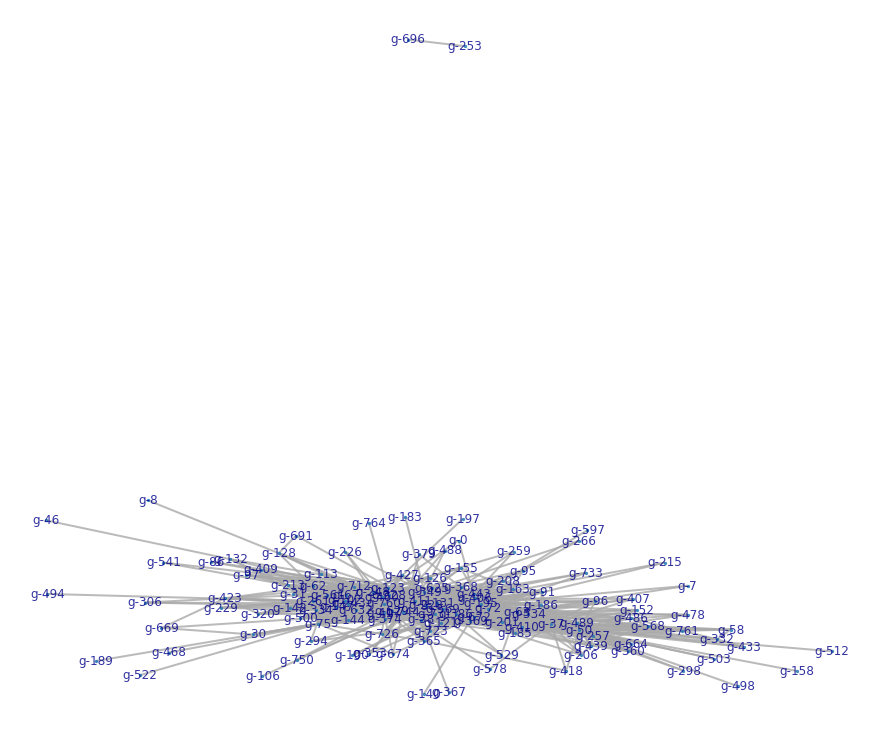

In [18]:
# https://www.kaggle.com/jpmiller/finding-patterns-in-the-scored-targets
import networkx as nx

pairs_df = (1-correlations).reset_index()
G = nx.from_pandas_edgelist(pairs_df[:904], source='level_0', target='level_1', edge_attr=0)

graph_opts = dict(arrows=False,
                  node_size=5,
                  width=2,
                  alpha=0.8,
                  font_size=12,
                  font_color='darkblue',
                  edge_color='darkgray'
                 )

fig= plt.figure(figsize=(12,10))
nx.draw_spring(G, with_labels=True, **graph_opts)

In [19]:
nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

[frozenset({'g-102',
            'g-106',
            'g-113',
            'g-123',
            'g-126',
            'g-131',
            'g-132',
            'g-142',
            'g-144',
            'g-147',
            'g-155',
            'g-163',
            'g-183',
            'g-189',
            'g-195',
            'g-197',
            'g-201',
            'g-208',
            'g-213',
            'g-226',
            'g-228',
            'g-229',
            'g-243',
            'g-248',
            'g-259',
            'g-261',
            'g-266',
            'g-30',
            'g-306',
            'g-31',
            'g-320',
            'g-328',
            'g-334',
            'g-349',
            'g-365',
            'g-367',
            'g-368',
            'g-374',
            'g-38',
            'g-409',
            'g-417',
            'g-423',
            'g-443',
            'g-46',
            'g-460',
            'g-468',
            'g-488',
            'g-49

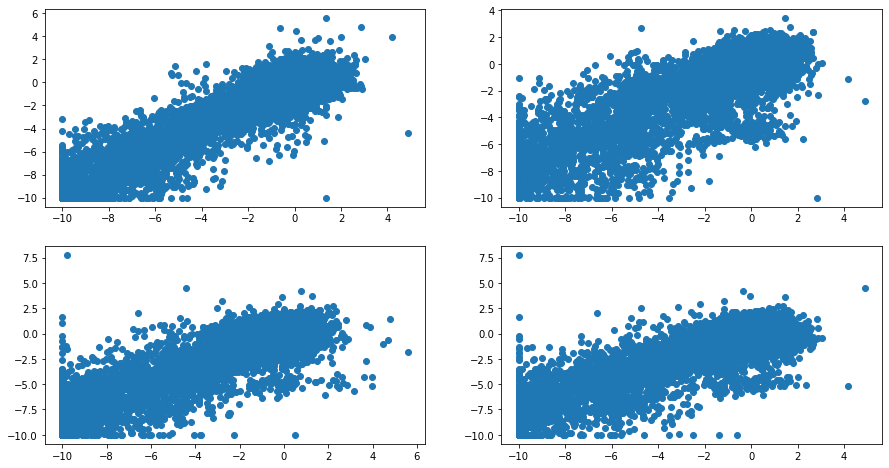

In [20]:
# some correlated examples
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.scatter(train_feat["g-50"], train_feat["g-37"])
plt.subplot(2,2,2)
plt.scatter(train_feat["g-50"], train_feat["g-672"])
plt.subplot(2,2,3)
plt.scatter(train_feat["g-37"], train_feat["g-489"])
plt.subplot(2,2,4)
plt.scatter(train_feat["g-50"], train_feat["g-489"])

772
0.9066974009777888


<BarContainer object of 370 artists>

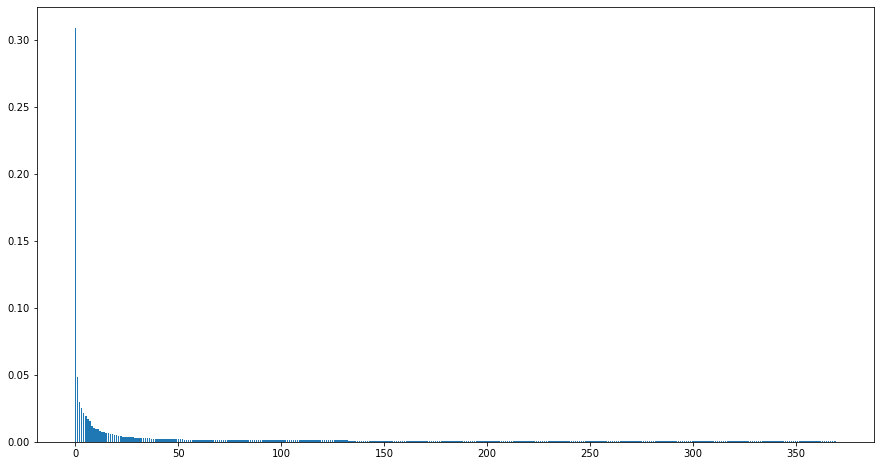

In [21]:
num = 370
print(len(g_feats))
pca = PCA(n_components=num)
pca.fit(train_feat[g_feats])
print(np.sum(np.array(pca.explained_variance_ratio_)))
plt.figure(figsize=(15,8))
plt.bar(range(num), np.array(pca.explained_variance_ratio_))

#mod_g_feats = pca.fit_transform(train_feat[g_feats])

#tsne = TSNE(random_state=0, metric="cosine")
#embs = tsne.fit_transform(mod_g_feats)
#plt.plot(embs[:,0], embs[:,1])

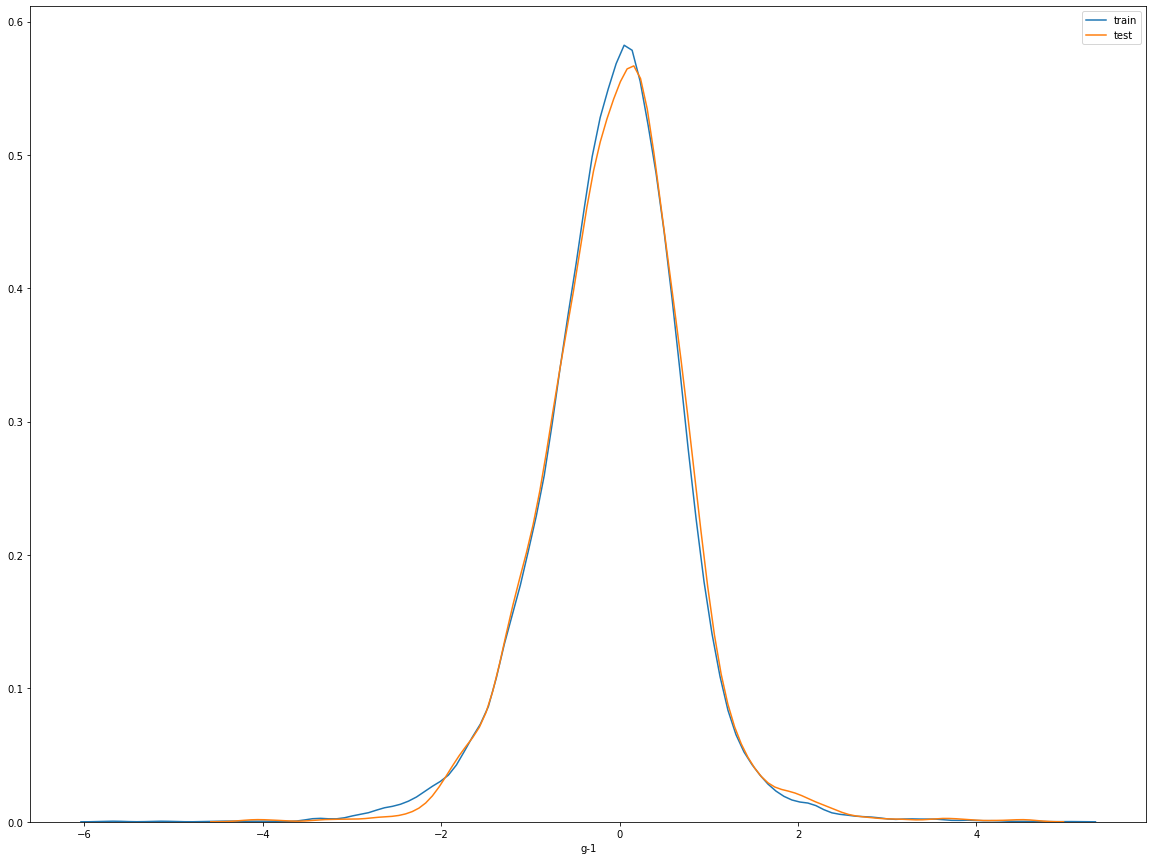

In [22]:
#for k in range(len(g_feats)//50 + 1):
#    plt.figure(figsize=(20,15))
#    for i in range(50*k, 50*(k+1)):
#        if i <= len(g_feats)-1:
#            plt.subplot(10,5,i+1-50*k)
#            sns.distplot(train_feat["g-"+str(i)], label = "train")
#            sns.distplot(test_feat["g-"+str(i)], label = "test")
#            plt.legend(loc="best")
plt.figure(figsize=(20,15))
sns.distplot(train_feat["g-"+str(1)], label = "train", hist=False)
sns.distplot(test_feat["g-"+str(1)], label = "test", hist=False)

## per row

Text(0.5, 1.0, 'test range distribution')

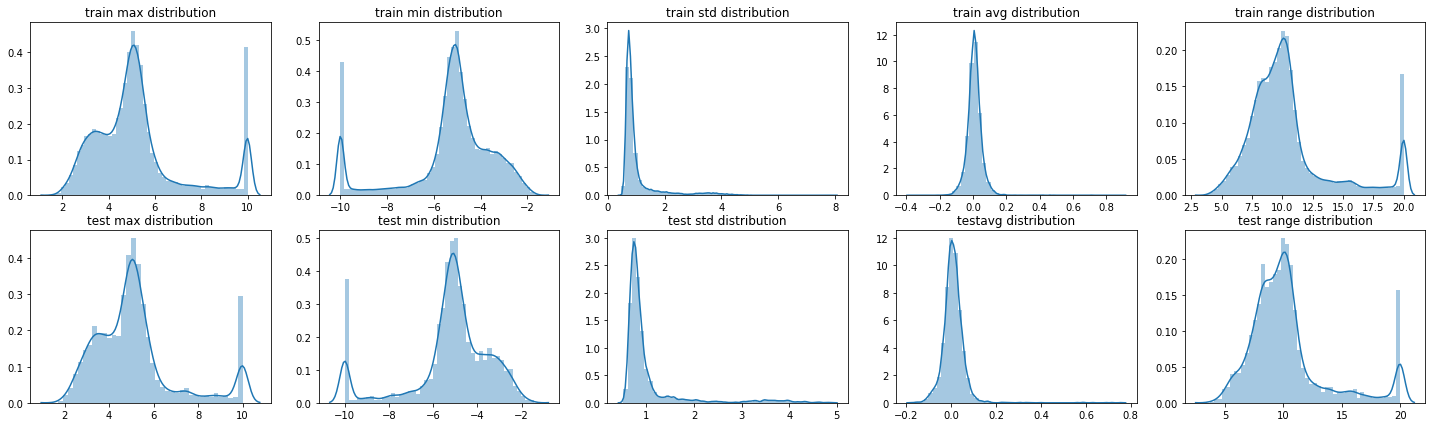

In [23]:
# there are many row with minimum value of -10 or maximum value of 10
plt.figure(figsize=(25,7))
plt.subplot(2,5,1)
sns.distplot(np.max(train_feat[g_feats], axis=1))
plt.title("train max distribution")
plt.subplot(2,5,2)
sns.distplot(np.min(train_feat[g_feats], axis=1))
plt.title("train min distribution")
plt.subplot(2,5,3)
sns.distplot(np.std(train_feat[g_feats], axis=1))
plt.title("train std distribution")
plt.subplot(2,5,4)
sns.distplot(np.mean(train_feat[g_feats], axis=1))
plt.title("train avg distribution")
plt.subplot(2,5,5)
sns.distplot(np.max(train_feat[g_feats], axis=1)-np.min(train_feat[g_feats], axis=1))
plt.title("train range distribution")

plt.subplot(2,5,6)
sns.distplot(np.max(test_feat[g_feats], axis=1))
plt.title("test max distribution")
plt.subplot(2,5,7)
sns.distplot(np.min(test_feat[g_feats], axis=1))
plt.title("test min distribution")
plt.subplot(2,5,8)
sns.distplot(np.std(test_feat[g_feats], axis=1))
plt.title("test std distribution")
plt.subplot(2,5,9)
sns.distplot(np.mean(test_feat[g_feats], axis=1))
plt.title("testavg distribution")
plt.subplot(2,5,10)
sns.distplot(np.max(test_feat[g_feats], axis=1)-np.min(test_feat[g_feats], axis=1))
plt.title("test range distribution")

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



train 768 392
test  766 690


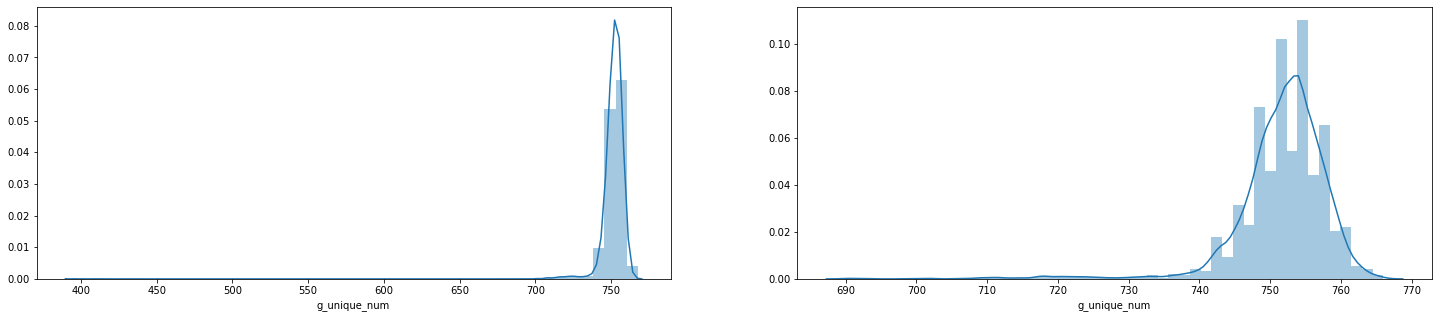

In [24]:
# unique value
def calc(row):
    return len(np.unique(row[g_feats].values))

tqdm_notebook.pandas(desc="progress")
train_feat["g_unique_num"] = train_feat.progress_apply(calc, axis=1)
test_feat["g_unique_num"] = test_feat.progress_apply(calc, axis=1)
print("train", np.max(train_feat["g_unique_num"]), np.min(train_feat["g_unique_num"]))
print("test ", np.max(test_feat["g_unique_num"]), np.min(test_feat["g_unique_num"]))
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
sns.distplot(train_feat["g_unique_num"])
plt.subplot(1,2,2)
sns.distplot(test_feat["g_unique_num"])

In [25]:
# unique value
def calc10(row):
    return sum(np.array(row[g_feats].values)==10)

def calc_10(row):
    return sum(np.array(row[g_feats].values)==-10)

tqdm_notebook.pandas(desc="progress")
train_feat["g10_num"] = train_feat.progress_apply(calc10, axis=1)
test_feat["g10_num"] = test_feat.progress_apply(calc10, axis=1)
print("train", np.max(train_feat["g10_num"]), np.min(train_feat["g10_num"]))
print("test ", np.max(test_feat["g10_num"]), np.min(test_feat["g10_num"]))

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



train 175 0
test  34 0


In [26]:
tqdm_notebook.pandas(desc="progress")
train_feat["g_10_num"] = train_feat.progress_apply(calc_10, axis=1)
test_feat["g_10_num"] = test_feat.progress_apply(calc_10, axis=1)
print("train", np.max(train_feat["g_10_num"]), np.min(train_feat["g_10_num"]))
print("test ", np.max(test_feat["g_10_num"]), np.min(test_feat["g_10_num"]))


train 204 0
test  30 0


In [27]:
# except an example with 392 unique values, others have at least 681
tmp = pd.DataFrame(train_feat["g_unique_num"].value_counts().reset_index(drop=False))
tmp.columns = ["g_unique_num", "no"]
np.transpose(tmp)

0     1     2     3     4     5     6     7     8     9    10  \
g_unique_num   754   753   752   751   755   756   750   749   757   748  758   
no            1887  1859  1804  1647  1634  1621  1491  1325  1251  1079  946   

               11   12   13   14   15   16   17   18   19   20   21   22   23  \
g_unique_num  747  759  746  745  760  744  761  743  762  742  741  763  740   
no            861  699  638  512  462  323  289  266  197  177  115   93   93   

               24   25   26   27   28   29   30   31   32   33   34   35   36  \
g_unique_num  739  738  764  736  726  737  722  735  765  733  715  724  717   
no             59   50   49   27   25   24   24   23   23   19   19   18   18   

               37   38   39   40   41   42   43   44   45   46   47   48   49  \
g_unique_num  734  723  728  729  732  718  719  731  725  720  727  766  721   
no             18   17   17   16   16   16   15   15   15   14   13   12   12   

               50   51   52   53   54   55   56   57   58   59   60   61   62  \
g_unique_num  730  714  708  712  709  710  716  707  713  711  706  703  768   
no             11   11    9    9    7    7    7    6    6    5    4    4    2   

               63   64   65   66   67   68   69   70   71   72   73   74   75  
g_unique_num  699  705  702  704  767  690  691  392  681  700  701  687  688  
no              2    2    2    2    1    1    1    1    1    1    1    1    1

In [28]:
# this example has 2 positive labels
tmp = train_feat[train_feat["g_unique_num"]==392][g_feats].copy()
print(tmp.T[16674].value_counts(), tmp.index)
tmp

-10.000    204
 10.000    175
 4.824       2
 7.601       2
 6.688       2
          ... 
-4.173       1
-8.021       1
 3.605       1
 1.092       1
-1.628       1
Name: 16674, Length: 392, dtype: int64 Int64Index([16674], dtype='int64')


g-0    g-1    g-2   g-3    g-4    g-5   g-6    g-7   g-8    g-9  \
16674  1.902  3.796  3.323  10.0  2.016 -2.356 -5.52  2.832 -10.0 -2.664   

       g-10    g-11    g-12  g-13   g-14  g-15  g-16  g-17   g-18  g-19  g-20  \
16674 -10.0 -0.3405 -0.0417  10.0 -3.093 -10.0 -10.0 -10.0  7.381 -10.0  -3.8   

       g-21  g-22  g-23  g-24    g-25   g-26   g-27  g-28   g-29  g-30  g-31  \
16674  1.33 -10.0 -10.0  10.0  0.9036  6.322 -1.416  10.0  4.479  10.0  7.95   

         g-32  g-33  g-34   g-35  g-36  g-37  g-38  g-39  g-40   g-41  g-42  \
16674 -0.1157  10.0 -10.0 -9.261 -10.0  4.78 -10.0  10.0 -10.0  5.301 -10.0   

       g-43  g-44  g-45  g-46   g-47   g-48   g-49   g-50  g-51  g-52  g-53  \
16674  10.0  10.0  10.0  10.0  1.668  3.675 -6.577  2.845 -10.0  10.0  10.0   

       g-54  g-55  g-56    g-57   g-58  g-59  g-60   g-61   g-62  g-63  g-64  \
16674  10.0 -10.0 -10.0  0.7102 -3.502  10.0  10.0 -6.278  9.912 -10.0  10.0   

        g-65   g-66  g-67  g-68   g-69  g-70  g-71  g-72   g-73  g-74  g-75  \
16674 -1.206 -5.525  -1.8  10.0 -1.534   4.9 -10.0 -10.0 -2.867  10.0 -10.0   

       g-76   g-77  g-78   g-79  g-80  g-81  g-82  g-83  g-84  g-85  g-86  \
16674 -10.0 -1.949 -10.0  6.258 -10.0  4.76 -10.0  10.0  10.0 -10.0  10.0   

       g-87  g-88  g-89   g-90   g-91   g-92  g-93  g-94   g-95   g-96  g-97  \
16674 -6.93  10.0 -10.0  7.753  5.019 -7.951  10.0  10.0  4.921 -1.839  10.0   

        g-98  g-99  g-100  g-101  g-102  g-103  g-104  g-105  g-106  g-107  \
16674  2.921 -10.0   10.0  1.408  2.823   10.0   10.0   9.91   10.0 -2.505   

        g-108  g-109  g-110  g-111  g-112   g-113  g-114  g-115  g-116  g-117  \
16674 -0.4007 -3.571  -10.0   10.0  -10.0 -0.5328   10.0 -2.442 -6.753   10.0   

       g-118  g-119  g-120  g-121  g-122  g-123  g-124  g-125  g-126  g-127  \
16674  9.492  4.997 -6.064  -10.0  -7.89   10.0  -10.0  -10.0  9.068  4.277   

       g-128  g-129  g-130  g-131  g-132  g-133  g-134   g-135  g-136  g-137  \
16674 -4.547  -10.0   10.0  5.528   10.0 -7.753  -10.0  0.5173   10.0  1.803   

       g-138  g-139  g-140  g-141  g-142  g-143  g-144   g-145  g-146  g-147  \
16674  4.789  -10.0  3.335  -10.0   10.0  -10.0   10.0 -0.5747  9.477   10.0   

       g-148  g-149  g-150  g-151  g-152  g-153  g-154  g-155  g-156  g-157  \
16674 -4.718   10.0  6.009  9.959  7.382  -10.0 -6.287   10.0  2.929  -10.0   

       g-158  g-159  g-160  g-161  g-162  g-163  g-164  g-165  g-166  g-167  \
16674 -2.149 -3.799  1.829 -8.021   7.14  8.969 -2.177  5.405 -1.587  -9.35   

       g-168  g-169  g-170  g-171  g-172  g-173   g-174  g-175  g-176  g-177  \
16674 -6.565   10.0   10.0   10.0  5.854  -10.0 -0.7259  7.402  9.243  4.824   

       g-178  g-179  g-180  g-181  g-182  g-183  g-184  g-185  g-186  g-187  \
16674  -10.0 -5.661  -10.0  8.591 -4.226 -2.836  -10.0  -10.0  -10.0  8.161   

       g-188  g-189  g-190  g-191  g-192  g-193  g-194  g-195  g-196  g-197  \
16674  -10.0  2.226  -10.0  6.663   10.0  -10.0  -10.0   4.46  7.866   10.0   

       g-198  g-199  g-200  g-201  g-202  g-203  g-204   g-205  g-206  g-207  \
16674   10.0  -10.0 -7.432  2.068  -10.0   10.0  -10.0  0.1465   10.0  5.313   

       g-208  g-209  g-210  g-211  g-212  g-213   g-214  g-215  g-216  g-217  \
16674   10.0  3.458   10.0 -4.523   10.0  8.365 -0.2274   10.0   10.0 -8.417   

       g-218  g-219  g-220  g-221  g-222  g-223  g-224  g-225  g-226  g-227  \
16674 -4.503   10.0  2.789  -10.0 -2.543 -6.311 -4.306  7.021   10.0  -10.0   

        g-228  g-229  g-230  g-231  g-232  g-233  g-234  g-235  g-236  g-237  \
16674 -0.0643 -4.814  9.537 -3.665   10.0  -10.0  9.509  7.398  -10.0  -10.0   

       g-238  g-239  g-240  g-241  g-242  g-243  g-244  g-245  g-246  g-247  \
16674 -9.056  -10.0   10.0  -10.0   10.0   10.0   10.0   10.0   10.0  -10.0   

       g-248  g-249  g-250  g-251  g-252  g-253  g-254  g-255  g-256  g-257  \
16674 -1.704   10.0 -3.015   10.0  -10.0 -7.445  -10.0  6.332  -10.0  -10.0   

       g-258  g-259 

In [29]:
tmp = train_feat[train_feat["g_unique_num"]==681][g_feats].copy()
print(tmp.T[22971].value_counts())
tmp

-10.0000    38
 10.0000    36
 0.6745      3
-4.3280      3
-3.5620      2
            ..
-1.9420      1
 2.3900      1
-1.6650      1
 1.6670      1
-1.4700      1
Name: 22971, Length: 681, dtype: int64


g-0     g-1    g-2    g-3     g-4    g-5    g-6    g-7   g-8    g-9  \
22971  8.057 -0.3999  1.018 -1.789  0.6745 -5.299  4.793 -1.168 -10.0 -1.275   

        g-10    g-11   g-12   g-13  g-14   g-15   g-16   g-17   g-18   g-19  \
22971 -5.577  0.4181  4.567  3.107 -2.39 -1.992 -7.533 -8.908 -1.524 -4.269   

         g-20    g-21   g-22   g-23   g-24   g-25   g-26    g-27   g-28  \
22971 -0.2691 -0.3336 -2.968 -4.424  2.764 -1.065 -6.385  0.9783 -1.711   

        g-29   g-30  g-31   g-32   g-33   g-34   g-35   g-36   g-37  g-38  \
22971  6.036 -4.289  10.0 -2.455  7.648 -4.226  1.859  3.574 -8.401  10.0   

        g-39  g-40   g-41   g-42  g-43   g-44   g-45   g-46   g-47   g-48  \
22971  7.282 -10.0 -8.567 -9.979  2.81  4.725 -7.539  1.814 -5.389 -6.403   

        g-49   g-50   g-51  g-52  g-53   g-54  g-55   g-56    g-57   g-58  \
22971  2.373 -3.528  3.586  2.45  10.0  8.018 -9.25 -1.936  0.3042  3.101   

        g-59   g-60   g-61  g-62   g-63   g-64   g-65   g-66   g-67   g-68  \
22971  6.785  1.251 -4.935 -10.0 -6.385  2.362  1.111 -2.742 -2.668  1.182   

       g-69   g-70   g-71  g-72  g-73  g-74  g-75   g-76   g-77   g-78   g-79  \
22971  2.96 -1.613  2.998 -10.0  6.94  10.0 -10.0  7.911 -0.345  1.063  4.128   

       g-80   g-81  g-82   g-83   g-84  g-85   g-86   g-87   g-88   g-89  \
22971 -6.05 -2.498  2.39  3.496  4.378  0.48  9.579 -5.495 -2.953 -3.714   

       g-90  g-91    g-92   g-93  g-94   g-95   g-96   g-97   g-98    g-99  \
22971  3.65  10.0 -0.5442 -5.339  1.74  1.483 -2.753  3.159 -2.799  0.4488   

       g-100  g-101  g-102  g-103  g-104  g-105  g-106  g-107  g-108  g-109  \
22971  7.512 -1.396  3.953  5.541  1.278  1.377  3.641  -10.0 -2.341 -4.477   

       g-110   g-111  g-112  g-113  g-114  g-115   g-116  g-117  g-118  g-119  \
22971 -1.403  0.5337 -6.043 -8.156 -0.891  2.493  0.4021  4.416  4.834  1.976   

        g-120  g-121  g-122  g-123  g-124  g-125  g-126  g-127  g-128  g-129  \
22971 -0.6902  -10.0   1.34   10.0 -1.355 -4.042  5.954 -4.762  -10.0 -1.215   

       g-130  g-131  g-132  g-133  g-134  g-135  g-136  g-137  g-138  g-139  \
22971  1.667   10.0  3.836  -10.0 -4.375  3.979  1.363  0.171 -5.551   4.06   

       g-140   g-141  g-142   g-143  g-144  g-145  g-146  g-147  g-148  \
22971  2.423 -0.6509  4.153 -0.5737  9.765  3.141   10.0  9.659  2.579   

        g-149  g-150  g-151  g-152  g-153  g-154  g-155  g-156  g-157  g-158  \
22971  0.6354  -1.69  1.534 -8.736 -0.097  -9.07  3.961 -2.306 -3.376  -2.11   

       g-159  g-160  g-161  g-162  g-163  g-164  g-165  g-166  g-167   g-168  \
22971 -1.675  -10.0  2.238  5.783  3.523   5.68 -8.944 -3.419  -6.53  0.6036   

       g-169  g-170  g-171  g-172  g-173  g-174  g-175   g-176  g-177  g-178  \
22971   10.0  7.828  2.096 -4.324 -7.763  1.149 -7.297 -0.3645  9.224  -10.0   

       g-179  g-180  g-181  g-182  g-183  g-184  g-185  g-186  g-187  g-188  \
22971 -3.554  2.418  7.138 -1.105 -5.807 -4.556 -8.861  -10.0 -4.339  2.367   

       g-189  g-190  g-191  g-192  g-193  g-194  g-195  g-196  g-197  g-198  \
22971 -4.734 -8.021  1.774  6.448  -5.63 -6.437 -5.247 -3.562   10.0  5.023   

       g-199  g-200  g-201  g-202  g-203   g-204  g-205  g-206  g-207  g-208  \
22971  -1.57 -1.681   5.06  -10.0 -4.492  0.2479  1.781 -1.946 -3.307  7.395   

        g-209  g-210  g-211  g-212  g-213   g-214  g-215  g-216  g-217  g-218  \
22971  0.4804  9.366   10.0 -0.566  5.962  0.2118   10.0  1.506 -1.774  -10.0   

       g-219  g-220  g-221  g-222  g-223  g-224  g-225  g-226   g-227  g-228  \
22971  1.472  3.222 -6.482 -3.491 -1.699 -5.105  9.372  8.389 -0.6175 -3.177   

       g-229  g-230  g-231  g-232   g-233  g-234  g-235  g-236  g-237  g-238  \
22971  6.944  7.161 -9.575  8.247 -0.1049  6.527   1.75  5.508 -4.463  -5.89   

       g-239  g-240  g-241   g-242  g-243  g-244  g-245  g-246   g-247  g-248  \
22971 -5.988  7.677 -6.632  0.3535   10.0  3.629  2.896 -3.806 -0.4447  9.786   

       g-249  g-250  g-251  g-252   g-253 

# cp-variables vs g-variables

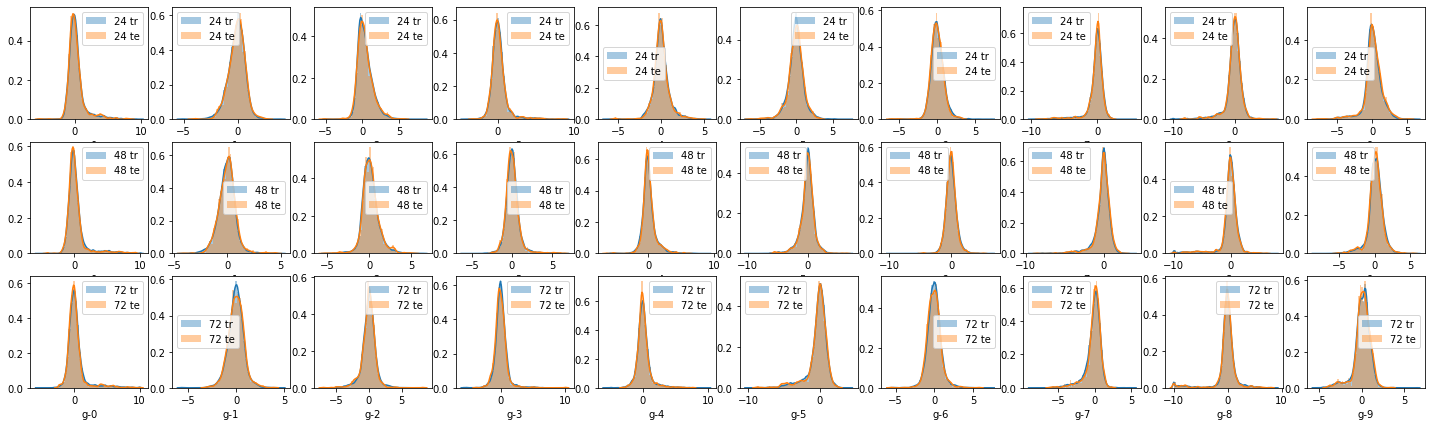

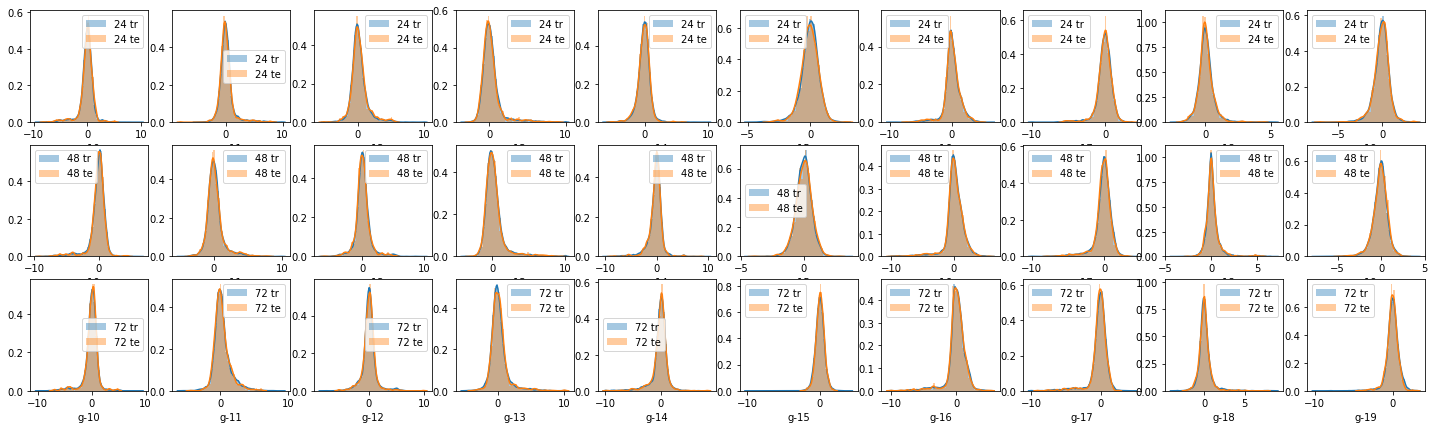

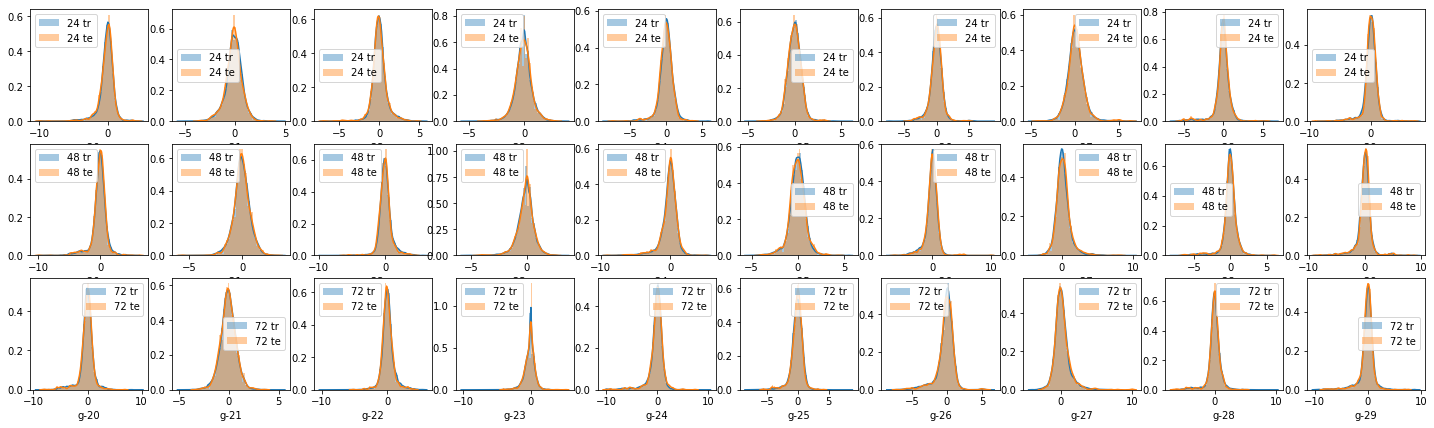

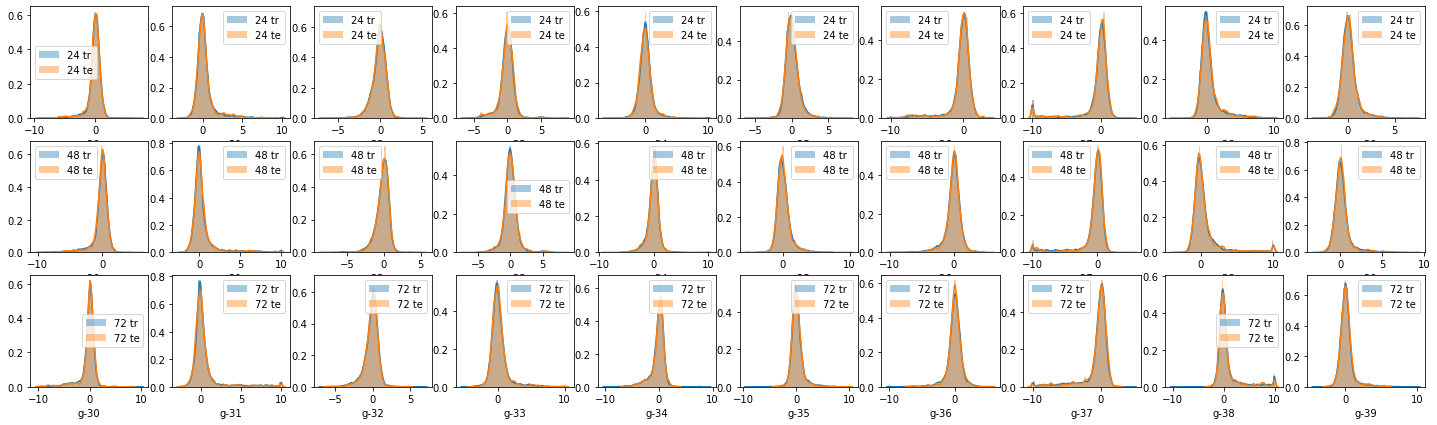

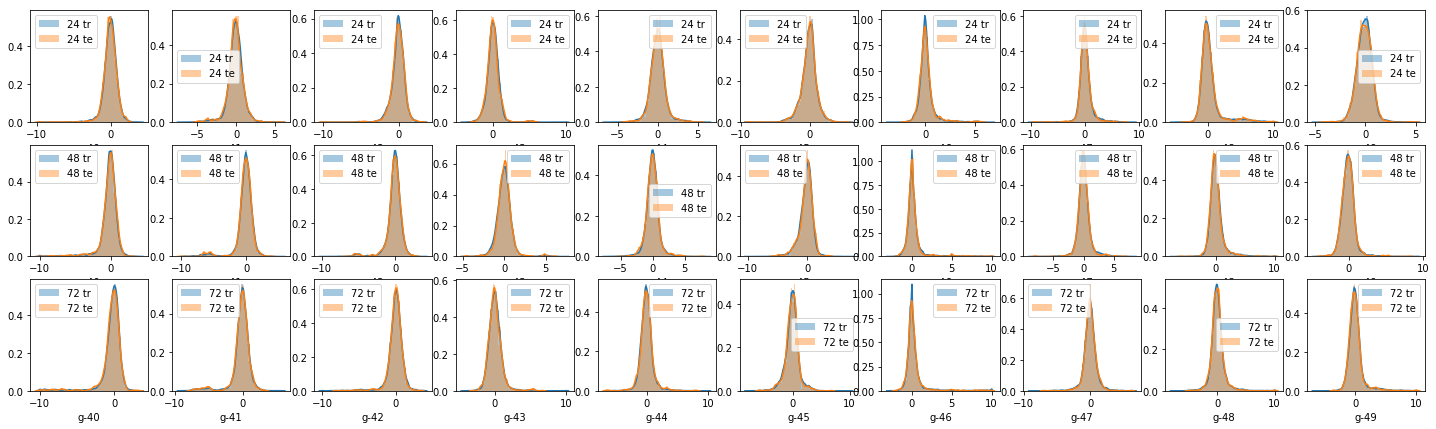

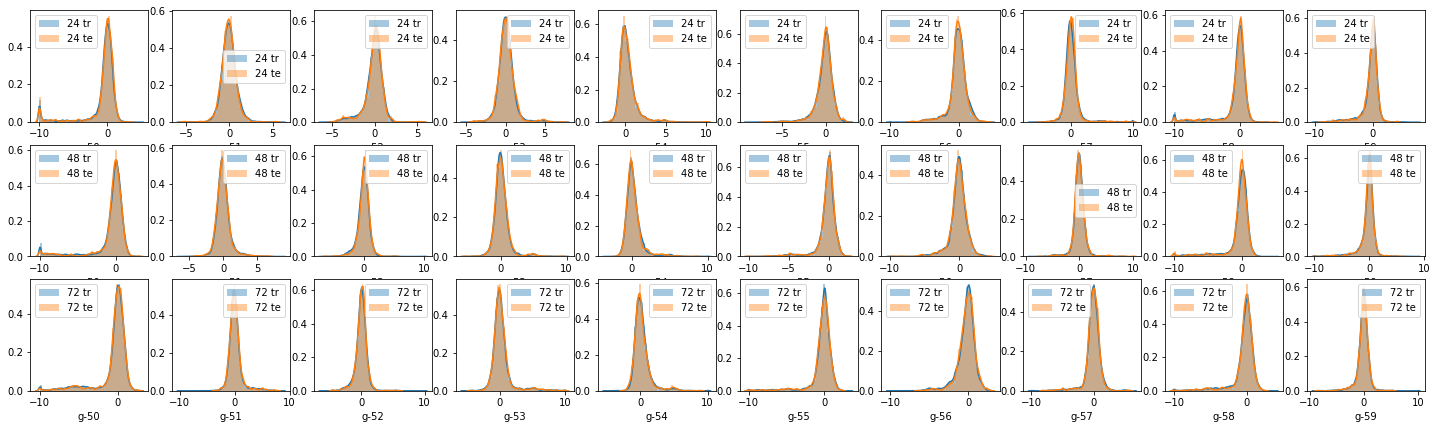

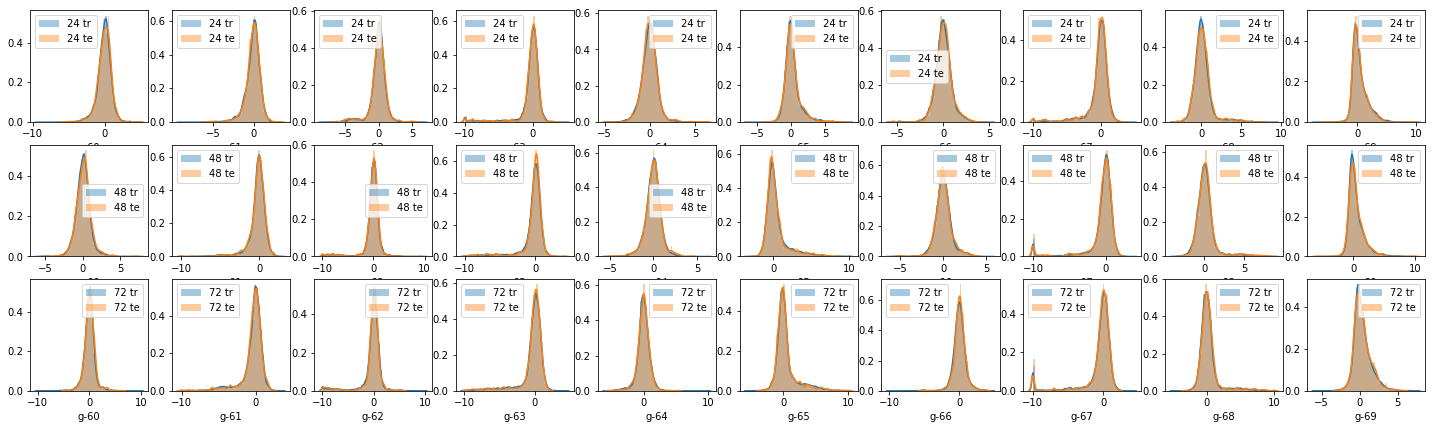

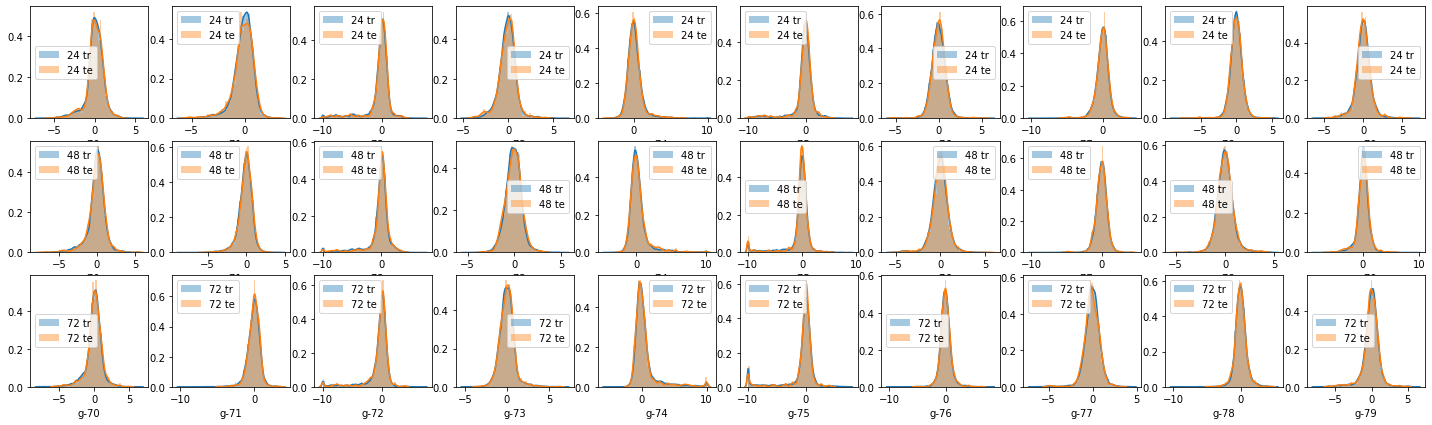

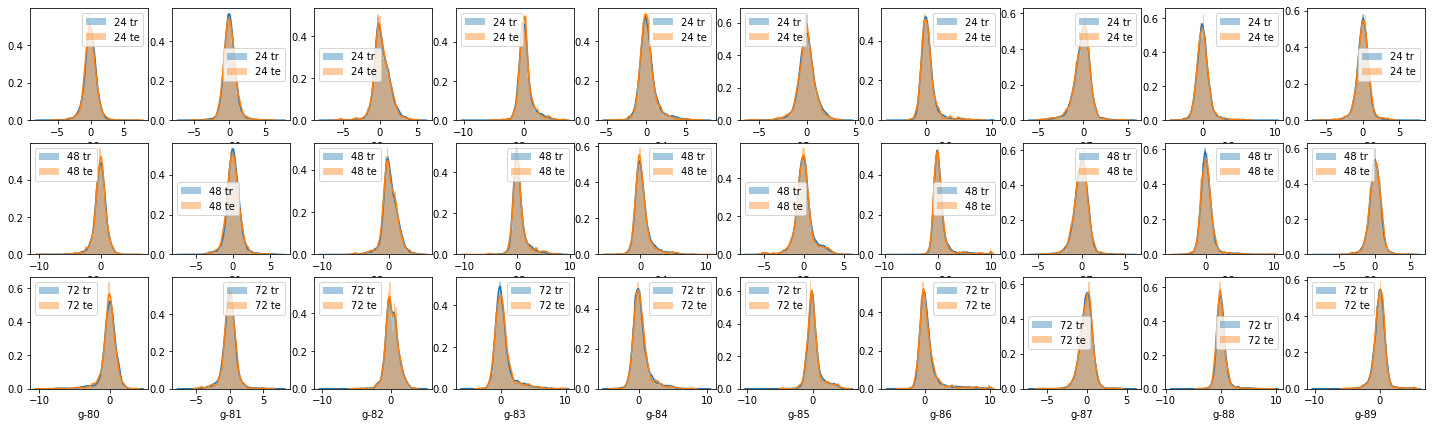

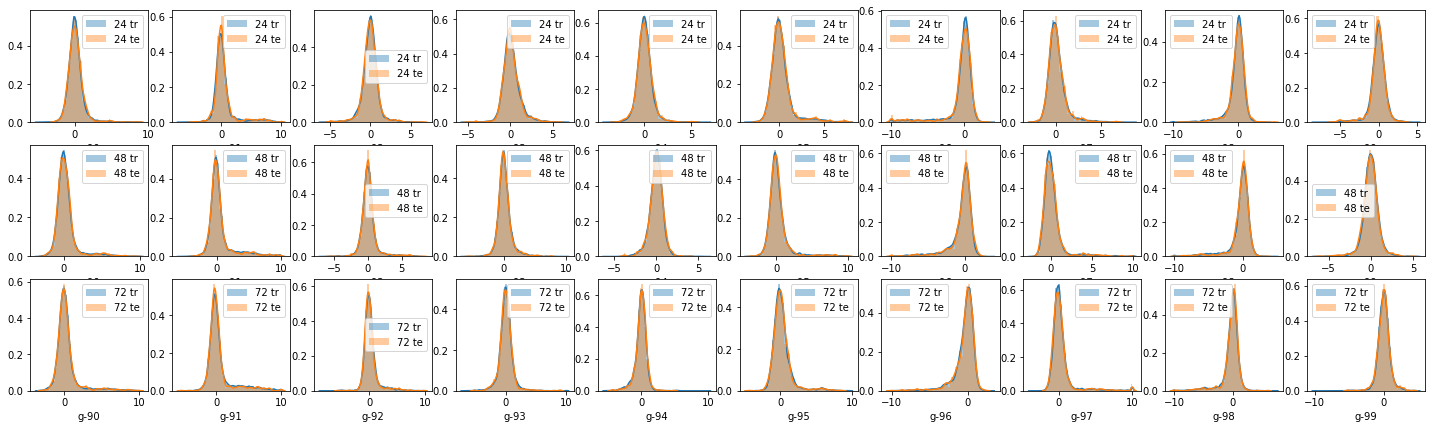

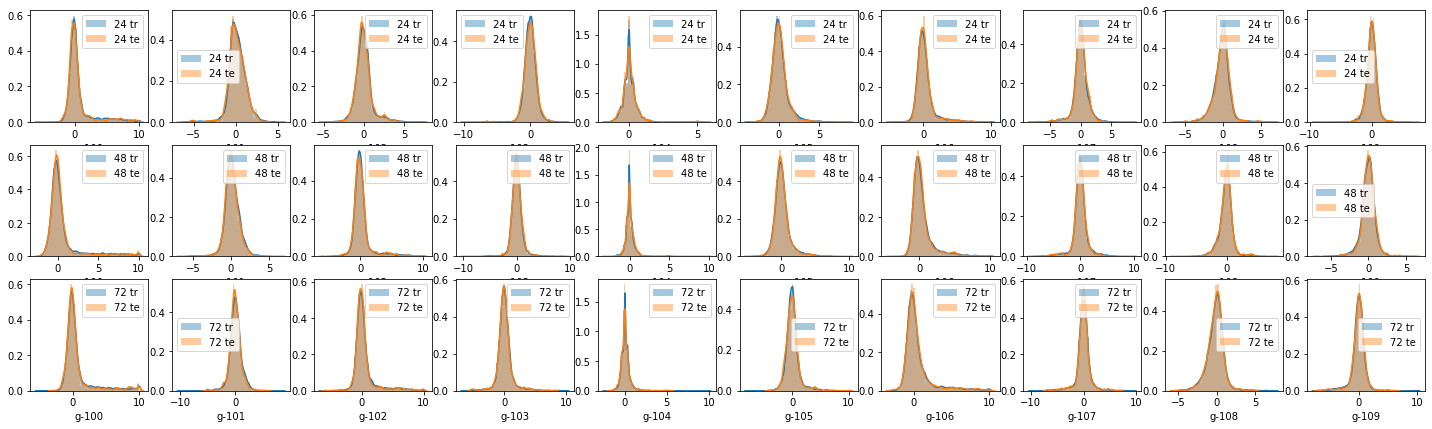

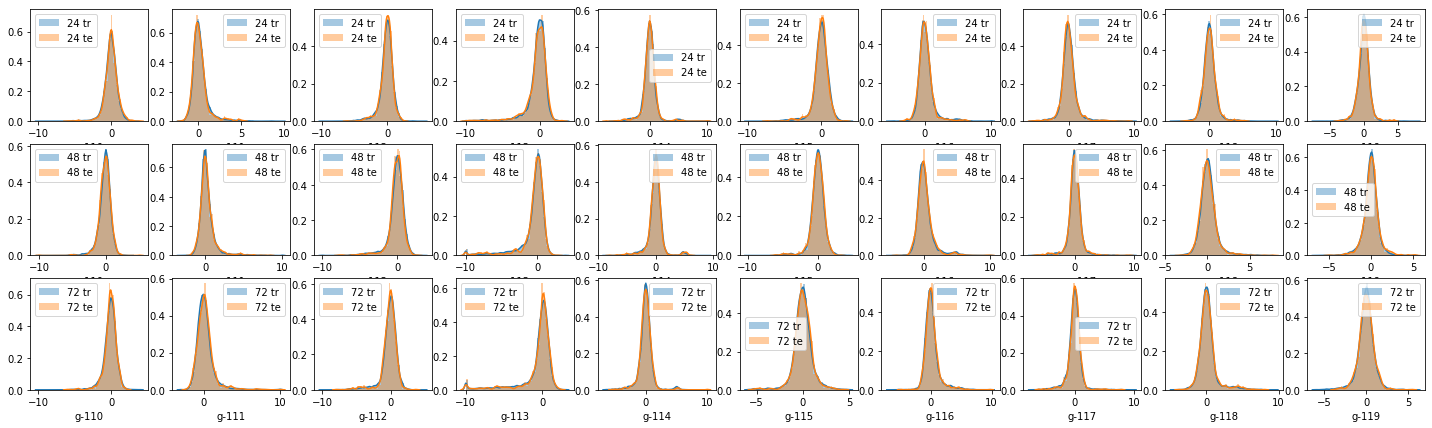

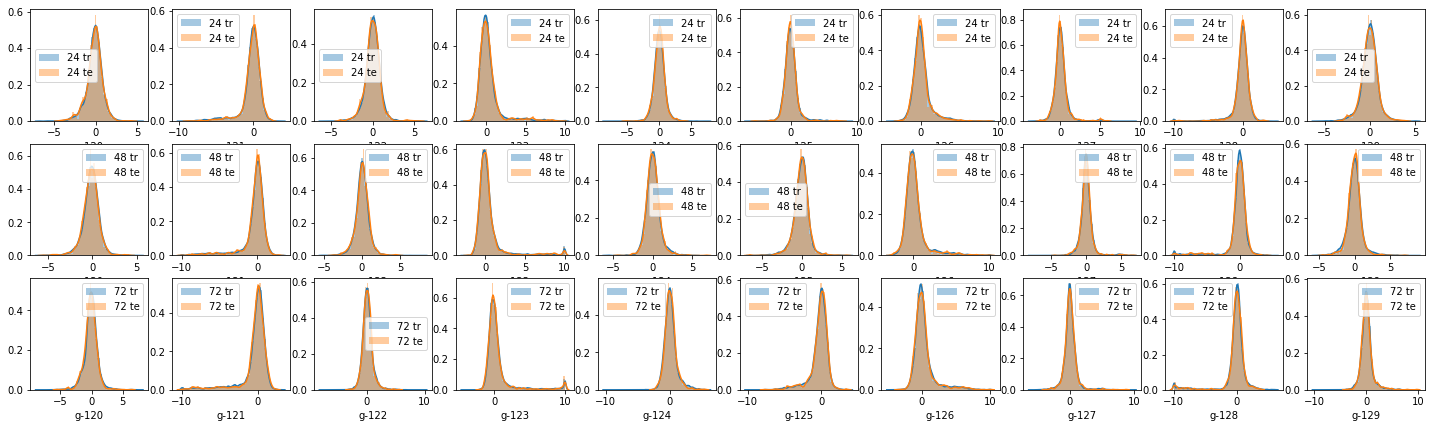

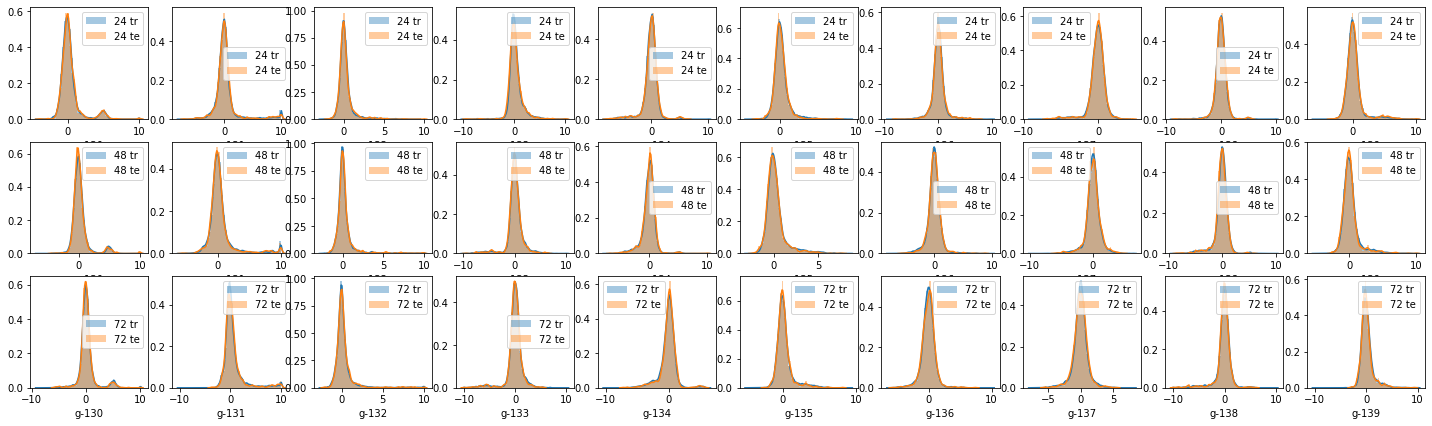

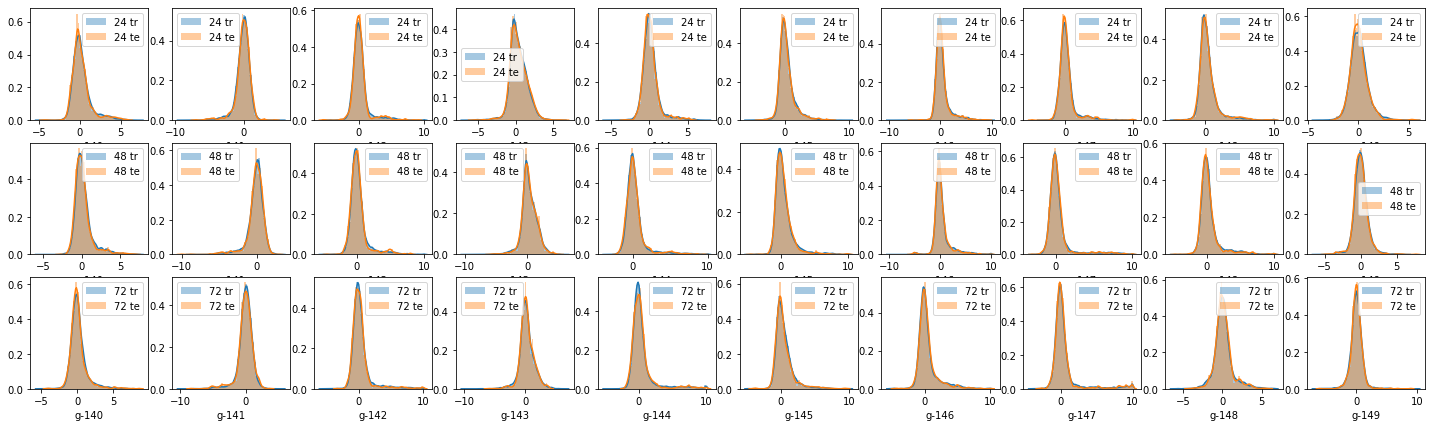

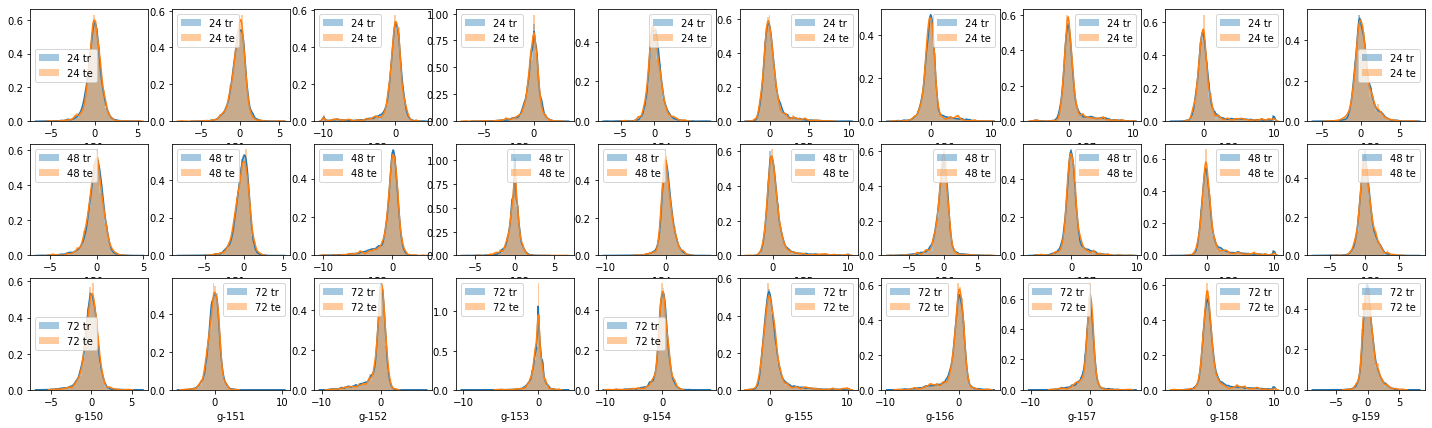

In [30]:
# "cp_time"
size = 10
for k in range(len(g_feats)//5//size + 1):
    plt.figure(figsize=(25,7))
    for ind, i in enumerate(range(size*k, size*(k+1))):
        if i <= len(g_feats)-1:
            plt.subplot(3,size,ind+1)
            sns.distplot(train_feat[train_feat.cp_time==24]["g-"+str(i)], label = "24 tr")
            sns.distplot(test_feat[test_feat.cp_time==24]["g-"+str(i)], label = "24 te")
            plt.legend(loc="best")
            plt.subplot(3,size,ind+1+size)
            sns.distplot(train_feat[train_feat.cp_time==48]["g-"+str(i)], label = "48 tr")
            sns.distplot(test_feat[test_feat.cp_time==48]["g-"+str(i)], label = "48 te")
            plt.legend(loc="best")
            plt.subplot(3,size,ind+1+2*size)
            sns.distplot(train_feat[train_feat.cp_time==72]["g-"+str(i)], label = "72 tr")
            sns.distplot(test_feat[test_feat.cp_time==72]["g-"+str(i)], label = "72 te")
            plt.legend(loc="best")

In [31]:
# "cp_dose"
size = 10
for k in range(len(c_feats)//5//size + 1):
    plt.figure(figsize=(25,7))
    for ind, i in enumerate(range(size*k, size*(k+1))):
        if i <= len(c_feats)-1:
            plt.subplot(2,size,ind+1)
            sns.distplot(train_feat[train_feat.cp_dose=="D1"]["c-"+str(i)], label = "d1 tr")
            sns.distplot(test_feat[test_feat.cp_dose=="D1"]["c-"+str(i)], label = "d1 te")
            plt.legend(loc="best")
            plt.subplot(2,size,ind+11)
            sns.distplot(train_feat[train_feat.cp_dose=="D2"]["c-"+str(i)], label = "d2 tr")
            sns.distplot(test_feat[test_feat.cp_dose=="D2"]["c-"+str(i)], label = "d2 te")
            plt.legend(loc="best")

NameError: name 'c_feats' is not defined

# c variables

In [32]:
# clear correlations in c variables
c_feats = [i for i in train_feat.columns if "c-" in i]
correlations = train_feat[c_feats].corr().abs()
correlations = (correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
correlations.tail(10)

c-22  c-32    0.690788
c-16  c-74    0.689653
c-74  c-99    0.686320
c-22  c-29    0.682454
      c-58    0.681121
c-37  c-74    0.671538
c-22  c-74    0.668643
c-58  c-74    0.664659
c-22  c-37    0.656201
c-16  c-22    0.619002
dtype: float64

In [33]:
correlations.head(10)

c-42  c-52    0.927873
c-13  c-73    0.924338
      c-26    0.924001
c-11  c-55    0.917963
c-6   c-33    0.917805
c-4   c-52    0.917748
c-38  c-63    0.917566
      c-94    0.917296
c-4   c-42    0.917120
c-13  c-94    0.915666
dtype: float64

In [34]:
correlations[correlations>0.9].shape

(173,)

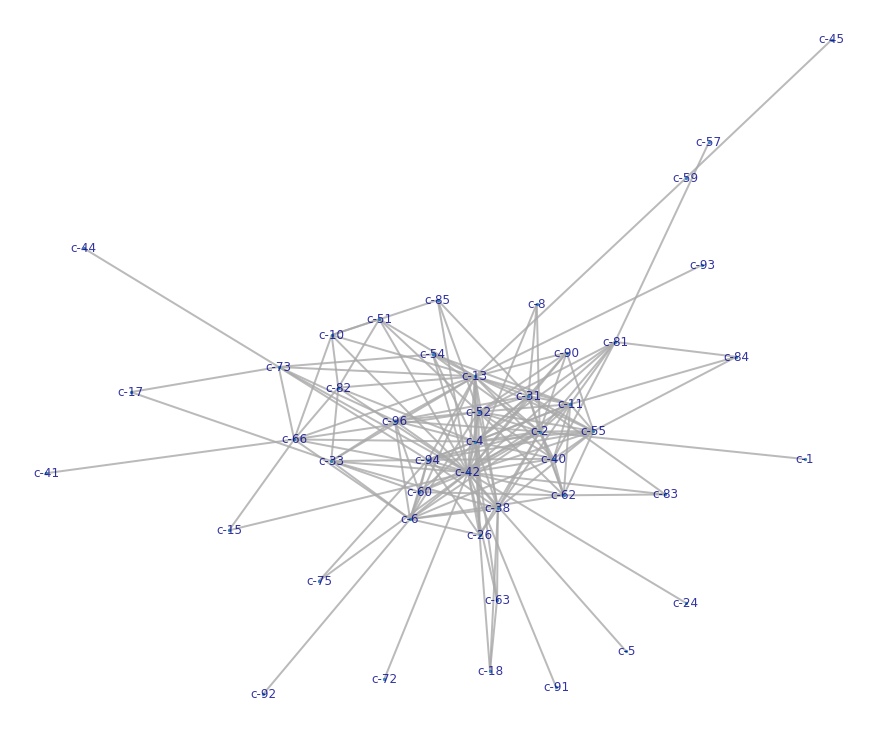

In [35]:
# https://www.kaggle.com/jpmiller/finding-patterns-in-the-scored-targets
import networkx as nx

pairs_df = (1-correlations).reset_index()
G = nx.from_pandas_edgelist(pairs_df[:173], source='level_0', target='level_1', edge_attr=0)

graph_opts = dict(arrows=False,
                  node_size=5,
                  width=2,
                  alpha=0.8,
                  font_size=12,
                  font_color='darkblue',
                  edge_color='darkgray'
                 )

fig= plt.figure(figsize=(12,10))
nx.draw_spring(G, with_labels=True, **graph_opts)

In [36]:
nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

[frozenset({'c-1',
            'c-11',
            'c-2',
            'c-31',
            'c-40',
            'c-52',
            'c-55',
            'c-57',
            'c-62',
            'c-8',
            'c-81',
            'c-83',
            'c-84',
            'c-90'}),
 frozenset({'c-13',
            'c-17',
            'c-33',
            'c-44',
            'c-45',
            'c-54',
            'c-59',
            'c-6',
            'c-60',
            'c-73',
            'c-92',
            'c-93',
            'c-96'}),
 frozenset({'c-10',
            'c-15',
            'c-24',
            'c-41',
            'c-42',
            'c-5',
            'c-51',
            'c-66',
            'c-72',
            'c-82',
            'c-85',
            'c-91'}),
 frozenset({'c-18', 'c-26', 'c-38', 'c-4', 'c-63', 'c-75', 'c-94'})]

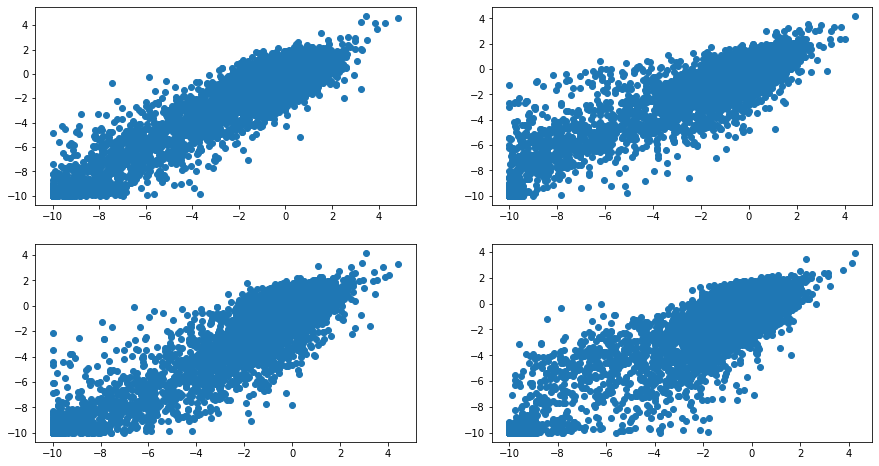

In [37]:
# some correlated examples
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.scatter(train_feat["c-52"], train_feat["c-42"])
plt.subplot(2,2,2)
plt.scatter(train_feat["c-13"], train_feat["c-73"])
plt.subplot(2,2,3)
plt.scatter(train_feat["c-13"], train_feat["c-26"])
plt.subplot(2,2,4)
plt.scatter(train_feat["c-33"], train_feat["c-6"])

In [38]:
from scipy.stats import norm, entropy
for k in range(len(c_feats)):
    print(k, train_feat["c-"+str(k)].mean() - test_feat["c-"+str(k)].mean())

0 0.005484599103602661
1 -0.015199976238237711
2 -0.02758869386641527
3 -0.01837465258039228
4 -0.040876557112116685
5 -0.04743218754865636
6 -0.06732999190138822
7 -0.009146780379147734
8 -0.02097792526163228
9 -0.07128510413535893
10 -0.07449599459650091
11 -0.042128122552162084
12 -0.022417876540218318
13 -0.04433413949829734
14 -0.010306771725345443
15 -0.04693379681595283
16 0.004416735221237644
17 -0.013190431190761798
18 -0.08157825794140772
19 -0.0022714827008329386
20 -0.03385761732728615
21 -0.051975367213535906
22 -0.07215560115299591
23 -0.009760046669611722
24 -0.039949228142497184
25 -0.064957388158282
26 -0.06855514151751929
27 -0.029879567931186624
28 -0.03198268023938777
29 -0.009947894903908572
30 -0.024193876058038133
31 -0.02611605124454386
32 0.012260398147578733
33 -0.04435510986534508
34 -0.05126966541626904
35 -0.014594250694293875
36 -0.04655745034621095
37 0.017747654510298472
38 -0.06341761141928282
39 -0.017731472070649734
40 -0.014799162288466117
41 -0.0605

In [39]:
#for k in range(len(c_feats)//5 + 1):
#    plt.figure(figsize=(20,15))
#    for i in range(5*k, 5*(k+1)):
#        if i <= len(c_feats)-1:
#            plt.subplot(5,1,i+1-5*k)
#            sns.distplot(train_feat["c-"+str(i)], label = "train")
#            sns.distplot(test_feat["c-"+str(i)], label = "test")
#            plt.legend(loc="best")

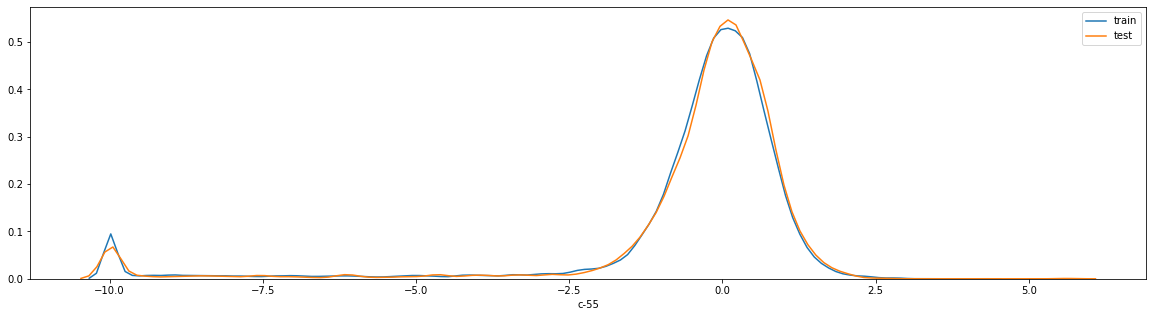

In [40]:
plt.figure(figsize=(20,5))
sns.distplot(train_feat["c-55"], label = "train", hist=False)
sns.distplot(test_feat["c-55"], label = "test", hist=False)

100
[0.85304354 0.01120614 0.00802776 0.00564012 0.00446381 0.00369287
 0.00361066 0.00321441 0.00305179 0.00289369]
0.8988447943353576


<BarContainer object of 10 artists>

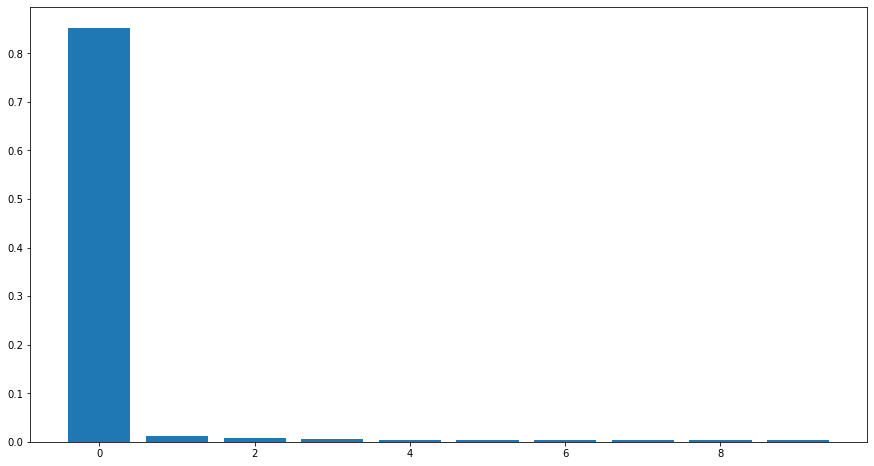

In [41]:
# TSNE
num = 10
print(len(c_feats))
pca = PCA(n_components=num)
pca.fit(train_feat[c_feats])
print(np.array(pca.explained_variance_ratio_))
print(np.sum(np.array(pca.explained_variance_ratio_)))
plt.figure(figsize=(15,8))
plt.bar(range(num), np.array(pca.explained_variance_ratio_))

#mod_c_feats = pca.fit_transform(train_feat[c_feats])

#tsne = TSNE(random_state=0, metric="cosine")
#embs = tsne.fit_transform(mod_c_feats)
#plt.plot(embs[:,0], embs[:,1])

## per row

Text(0.5, 1.0, 'test range distribution')

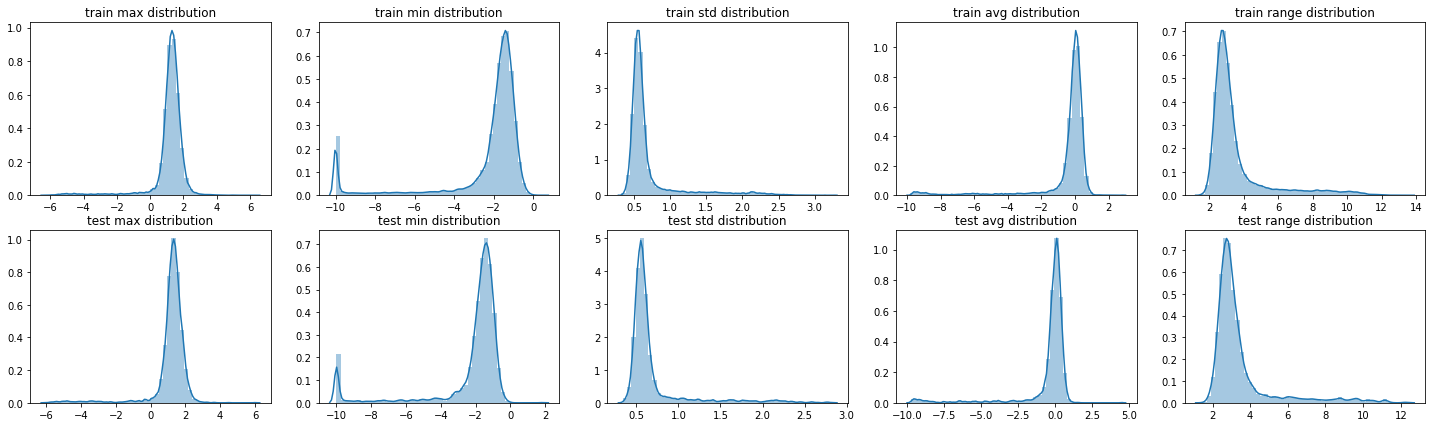

In [42]:
# there are many row with minimum value of -10 or maximum value of 10
plt.figure(figsize=(25,7))
plt.subplot(2,5,1)
sns.distplot(np.max(train_feat[c_feats], axis=1))
plt.title("train max distribution")
plt.subplot(2,5,2)
sns.distplot(np.min(train_feat[c_feats], axis=1))
plt.title("train min distribution")
plt.subplot(2,5,3)
sns.distplot(np.std(train_feat[c_feats], axis=1))
plt.title("train std distribution")
plt.subplot(2,5,4)
sns.distplot(np.mean(train_feat[c_feats], axis=1))
plt.title("train avg distribution")
plt.subplot(2,5,5)
sns.distplot(np.max(train_feat[c_feats], axis=1)-np.min(train_feat[c_feats], axis=1))
plt.title("train range distribution")

plt.subplot(2,5,6)
sns.distplot(np.max(test_feat[c_feats], axis=1))
plt.title("test max distribution")
plt.subplot(2,5,7)
sns.distplot(np.min(test_feat[c_feats], axis=1))
plt.title("test min distribution")
plt.subplot(2,5,8)
sns.distplot(np.std(test_feat[c_feats], axis=1))
plt.title("test std distribution")
plt.subplot(2,5,9)
sns.distplot(np.mean(test_feat[c_feats], axis=1))
plt.title("test avg distribution")
plt.subplot(2,5,10)
sns.distplot(np.max(test_feat[c_feats], axis=1)-np.min(test_feat[c_feats], axis=1))
plt.title("test range distribution")

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



train 100 8
test  100 14


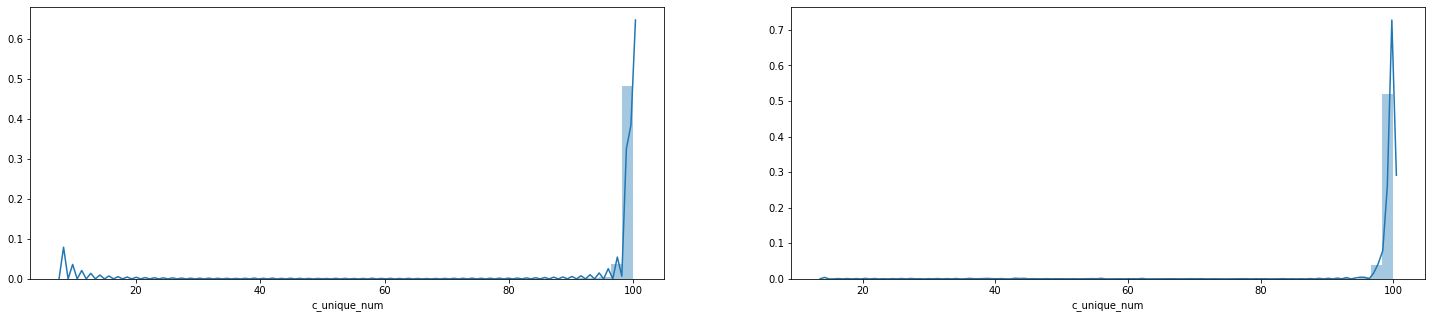

In [43]:
# unique value
def calc(row):
    return len(np.unique(row[c_feats].values))

tqdm_notebook.pandas(desc="progress")
train_feat["c_unique_num"] = train_feat.progress_apply(calc, axis=1)
test_feat["c_unique_num"] = test_feat.progress_apply(calc, axis=1)

print("train", np.max(train_feat["c_unique_num"]), np.min(train_feat["c_unique_num"]))
print("test ", np.max(test_feat["c_unique_num"]), np.min(test_feat["c_unique_num"]))

plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
sns.distplot(train_feat["c_unique_num"])
plt.subplot(1,2,2)
sns.distplot(test_feat["c_unique_num"])

In [44]:
tmp = pd.DataFrame(train_feat["c_unique_num"].value_counts().reset_index(drop=False))
tmp.columns = ["c_unique_num", "no"]
np.transpose(tmp)

0     1     2    3   4   5   6   7   8   9   10  11  12  13  \
c_unique_num    100    99    98   97  96  95  94  91  92  93  87  46  32  34   
no            14207  5317  1289  243  94  51  34  21  21  18  16  15  15  14   

              14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  \
c_unique_num  45  50  39  86  38  90  54  42  37  49  52  28  44  89  88  31   
no            14  14  14  14  14  14  13  13  13  12  12  12  12  11  11  11   

              30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  \
c_unique_num  25  41  35  84  48  73  27  47  26  58  85  40  33  64  51  24   
no            11  11  11  10  10  10  10  10  10  10  10  10  10   9   9   9   

              46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  \
c_unique_num  30  72  21  71  61  59  57  74  78  66  43  20  19  60  53  79   
no             9   9   8   8   8   8   8   8   7   7   7   7   7   7   7   6   

              62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  \
c_unique_num  83  70  29  65  82  62  36  63  69  56  81  77  55  23  68  22   
no             6   6   6   6   5   5   5   5   5   4   4   4   4   4   4   4   

              78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  
c_unique_num  76  75  13  18  80  11  15  12  67  17  14   8  10   9  16  
no             4   3   3   3   3   3   2   2   2   1   1   1   1   1   1

In [45]:
tmp = train_feat[train_feat["c_unique_num"]==8][c_feats].copy()
print(tmp.T[1021].value_counts())
tmp

-10.000    69
-9.803     25
-8.583      1
-7.314      1
-9.839      1
-5.585      1
-9.038      1
-5.934      1
Name: 1021, dtype: int64


c-0   c-1   c-2   c-3   c-4   c-5   c-6   c-7   c-8    c-9  c-10  c-11  \
1021 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -8.583 -10.0 -10.0   

      c-12  c-13  c-14  c-15  c-16  c-17  c-18  c-19  c-20  c-21  c-22   c-23  \
1021 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -9.038   

      c-24   c-25   c-26   c-27   c-28   c-29   c-30   c-31   c-32   c-33  \
1021 -10.0 -9.803 -9.803 -9.803 -9.803 -9.803 -9.803 -9.803 -9.803 -9.803   

       c-34   c-35   c-36   c-37   c-38   c-39   c-40   c-41   c-42   c-43  \
1021 -9.803 -9.803 -9.803 -9.803 -9.803 -9.803 -9.803 -9.803 -9.803 -9.803   

       c-44   c-45   c-46   c-47   c-48   c-49  c-50  c-51  c-52  c-53  c-54  \
1021 -9.803 -9.803 -9.803 -9.803 -9.803 -9.803 -10.0 -10.0 -10.0 -10.0 -10.0   

      c-55  c-56  c-57   c-58  c-59  c-60  c-61  c-62  c-63  c-64  c-65  c-66  \
1021 -10.0 -10.0 -10.0 -7.314 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0   

      c-67  c-68   c-69  c-70  c-71  c-72  c-73   c-74  c-75   c-76  c-77  \
1021 -10.0 -10.0 -9.839 -10.0 -10.0 -10.0 -10.0 -5.934 -10.0 -5.585 -10.0   

      c-78  c-79  c-80  c-81  c-82  c-83  c-84  c-85  c-86  c-87  c-88  c-89  \
1021 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0   

      c-90  c-91  c-92  c-93  c-94  c-95  c-96  c-97  c-98  c-99  
1021 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0

In [46]:
train_feat[train_feat["c_unique_num"]==11][c_feats]

c-0    c-1    c-2    c-3    c-4    c-5    c-6    c-7    c-8    c-9  \
10399 -9.966 -9.966 -9.966 -9.966 -9.966 -9.966 -9.966 -9.966 -9.966 -7.840   
16234 -9.936 -9.936 -9.936 -9.936 -9.936 -9.936 -9.936 -9.936 -9.936 -8.603   
20508 -9.961 -9.961 -9.961 -9.961 -9.961 -9.961 -9.961 -9.961 -9.961 -7.982   

        c-10   c-11   c-12   c-13   c-14   c-15   c-16   c-17   c-18   c-19  \
10399 -9.966 -9.966 -9.966 -9.966 -9.966 -9.966 -9.966 -9.966 -9.966 -9.487   
16234 -9.936 -9.936 -9.936 -9.936 -9.723 -9.936 -9.936 -9.936 -9.936 -9.936   
20508 -9.961 -9.961 -9.961 -9.961 -9.961 -9.961 -9.961 -9.961 -9.961 -9.961   

        c-20   c-21   c-22   c-23   c-24   c-25   c-26   c-27   c-28   c-29  \
10399 -9.966 -9.966 -9.966 -9.966 -9.966 -9.813 -9.813 -9.813 -9.813 -9.813   
16234 -9.936 -9.936 -9.936 -9.126 -9.936 -9.809 -9.809 -9.809 -9.809 -9.809   
20508 -9.961 -9.961 -9.961 -9.961 -9.961 -9.876 -9.876 -9.876 -9.876 -9.876   

        c-30   c-31   c-32   c-33   c-34   c-35   c-36   c-37   c-38   c-39  \
10399 -9.813 -9.813 -9.813 -9.813 -9.813 -9.813 -9.813 -9.813 -9.813 -9.813   
16234 -9.809 -9.809 -9.809 -9.809 -9.809 -9.809 -9.809 -9.809 -9.809 -9.809   
20508 -9.876 -9.876 -9.876 -9.876 -9.876 -9.876 -9.876 -9.876 -9.876 -9.876   

        c-40   c-41   c-42   c-43   c-44   c-45   c-46   c-47   c-48   c-49  \
10399 -9.813 -9.813 -9.813 -9.813 -9.813 -9.813 -9.813 -9.813 -9.813 -9.813   
16234 -9.809 -9.809 -9.809 -9.809 -9.809 -9.809 -9.809 -9.809 -9.809 -9.809   
20508 -9.876 -9.876 -9.876 -9.876 -9.876 -9.876 -9.876 -9.876 -9.876 -9.876   

         c-50  c-51  c-52  c-53  c-54  c-55    c-56  c-57   c-58  c-59  c-60  \
10399 -10.000 -10.0 -10.0 -10.0 -10.0 -10.0  -9.800 -10.0 -7.675 -10.0 -10.0   
16234 -10.000 -10.0 -10.0 -10.0 -10.0 -10.0 -10.000 -10.0 -7.073 -10.0 -10.0   
20508  -9.876 -10.0 -10.0 -10.0 -10.0 -10.0  -9.802 -10.0 -7.088 -10.0 -10.0   

       c-61  c-62  c-63  c-64  c-65  c-66  c-67  c-68   c-69  c-70  c-71  \
10399 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -9.482 -10.0 -10.0   
16234 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -9.502 -10.0 -10.0   
20508 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -9.472 -10.0 -10.0   

       c-72  c-73   c-74  c-75   c-76  c-77  c-78  c-79  c-80  c-81  c-82  \
10399 -10.0 -10.0 -5.815 -10.0 -5.600 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0   
16234 -10.0 -10.0 -5.993 -10.0 -5.654 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0   
20508 -10.0 -10.0 -5.729 -10.0 -5.271 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0   

       c-83  c-84  c-85  c-86  c-87  c-88  c-89  c-90  c-91  c-92  c-93  c-94  \
10399 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0   
16234 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0   
20508 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0   

         c-95  c-96  c-97  c-98   c-99  
10399 -10.000 -10.0 -10.0 -10.0 -9.987  
16234 -10.000 -10.0 -10.0 -10.0 -9.668  
20508  -9.757 -10.0 -10.0 -10.0 -9.538

In [47]:
train_feat[train_feat["c_unique_num"]==12][c_feats]

c-0     c-1     c-2     c-3     c-4     c-5     c-6    c-7     c-8  \
5860 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -9.472 -10.000   
9696  -9.943  -9.943  -9.943  -9.943  -9.943  -9.943  -9.943 -9.943  -9.943   

        c-9    c-10    c-11    c-12    c-13    c-14    c-15    c-16    c-17  \
5860 -6.488 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000   
9696 -9.943  -9.943  -9.943  -9.943  -9.943  -8.335  -9.943  -9.943  -9.943   

        c-18    c-19    c-20    c-21   c-22   c-23    c-24   c-25   c-26  \
5860 -10.000 -10.000 -10.000 -10.000 -9.203 -8.796 -10.000 -9.821 -9.821   
9696  -9.943  -9.943  -9.943  -9.943 -9.943 -9.635  -9.943 -9.926 -9.926   

       c-27   c-28   c-29   c-30   c-31   c-32   c-33   c-34   c-35   c-36  \
5860 -9.821 -9.821 -9.821 -9.821 -9.821 -9.821 -9.821 -9.821 -9.821 -9.821   
9696 -9.926 -9.926 -9.926 -9.926 -9.926 -9.926 -9.926 -9.926 -9.926 -9.926   

       c-37   c-38   c-39   c-40   c-41   c-42   c-43   c-44   c-45   c-46  \
5860 -9.821 -9.821 -9.821 -9.821 -9.821 -9.821 -9.821 -9.821 -9.821 -9.821   
9696 -7.633 -9.926 -9.926 -9.926 -9.926 -9.926 -9.926 -9.926 -9.926 -9.926   

       c-47   c-48   c-49    c-50  c-51  c-52  c-53  c-54  c-55    c-56  c-57  \
5860 -9.821 -9.821 -9.821 -10.000 -10.0 -10.0 -10.0 -10.0 -10.0  -9.765 -10.0   
9696 -9.926 -9.926 -9.926  -9.994 -10.0 -10.0 -10.0 -10.0 -10.0 -10.000 -10.0   

       c-58  c-59  c-60  c-61  c-62  c-63  c-64  c-65  c-66  c-67  c-68  \
5860 -7.431 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0   
9696 -7.124 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0 -10.0   

       c-69  c-70  c-71  c-72  c-73   c-74    c-75   c-76    c-77    c-78  \
5860 -9.154 -10.0 -10.0 -10.0 -10.0 -5.805  -9.894 -5.500  -9.894  -9.894   
9696 -9.522 -10.0 -10.0 -10.0 -10.0 -5.710 -10.000 -5.393 -10.000 -10.000   

        c-79    c-80    c-81    c-82    c-83    c-84    c-85    c-86    c-87  \
5860  -9.894  -9.894  -9.894  -9.894  -9.894  -9.894  -9.894  -9.894  -9.894   
9696 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000   

        c-88    c-89    c-90    c-91    c-92    c-93    c-94    c-95    c-96  \
5860  -9.894  -9.894  -9.894  -9.894  -9.894  -9.894  -9.894  -9.894  -9.894   
9696 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000   

        c-97    c-98   c-99  
5860  -9.894  -9.894 -9.894  
9696 -10.000 -10.000 -9.693

In [48]:
train_feat[train_feat["c_unique_num"]==20][c_feats]

c-0     c-1     c-2     c-3     c-4     c-5     c-6    c-7     c-8  \
2699   -9.974  -9.974  -9.974  -9.603  -9.974  -9.974  -9.974 -6.110  -9.974   
7742  -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -8.319 -10.000   
8567  -10.000 -10.000 -10.000  -9.338 -10.000 -10.000 -10.000 -7.498 -10.000   
12754 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -8.463 -10.000   
19766 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -6.455 -10.000   
20195  -9.992  -9.992  -9.992  -9.431  -9.992  -9.992  -9.992 -7.781  -9.992   
20652 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -8.565 -10.000   

         c-9    c-10    c-11    c-12    c-13    c-14    c-15    c-16    c-17  \
2699  -7.971  -9.974  -9.974  -9.974  -9.974  -9.974  -9.974  -9.168  -9.974   
7742  -6.068 -10.000 -10.000 -10.000 -10.000  -7.869 -10.000 -10.000 -10.000   
8567  -9.272 -10.000 -10.000 -10.000 -10.000  -9.554 -10.000  -9.515 -10.000   
12754 -6.196 -10.000 -10.000 -10.000 -10.000  -9.626 -10.000  -8.831 -10.000   
19766 -6.415 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000  -9.982 -10.000   
20195 -6.145  -9.992  -9.992  -9.992  -9.992  -9.864  -9.992  -9.753  -9.992   
20652 -7.005 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000  -8.569 -10.000   

         c-18    c-19    c-20    c-21    c-22    c-23    c-24   c-25   c-26  \
2699   -9.974  -9.115  -9.974  -9.974  -9.974  -8.309  -9.974 -9.825 -9.825   
7742  -10.000 -10.000 -10.000 -10.000  -7.867  -8.320 -10.000 -9.892 -9.892   
8567  -10.000 -10.000 -10.000 -10.000  -9.020  -7.392 -10.000 -9.730 -9.730   
12754 -10.000 -10.000 -10.000 -10.000 -10.000  -7.802 -10.000 -9.863 -9.863   
19766 -10.000 -10.000 -10.000 -10.000  -8.244 -10.000 -10.000 -9.873 -9.873   
20195  -9.992  -9.992  -9.992  -9.992  -8.839  -9.992  -9.992 -9.889 -9.889   
20652 -10.000 -10.000 -10.000 -10.000  -8.639  -9.688 -10.000 -9.787 -9.787   

        c-27   c-28   c-29   c-30   c-31   c-32   c-33   c-34   c-35   c-36  \
2699  -9.825 -9.825 -9.825 -9.825 -9.825 -9.825 -9.825 -9.825 -9.825 -9.825   
7742  -9.892 -9.892 -9.865 -9.892 -9.892 -9.892 -9.892 -9.892 -9.892 -9.892   
8567  -9.730 -9.730 -9.730 -9.730 -9.730 -9.730 -9.730 -9.730 -9.730 -9.730   
12754 -9.863 -9.863 -9.863 -9.863 -9.863 -9.863 -9.863 -9.863 -8.370 -9.863   
19766 -9.873 -9.873 -8.069 -9.873 -9.873 -9.873 -9.873 -9.873 -9.873 -9.873   
20195 -9.889 -9.889 -9.889 -9.889 -9.889 -9.889 -9.889 -9.889 -9.889 -9.889   
20652 -9.787 -9.787 -9.787 -9.787 -9.787 -9.787 -9.787 -9.787 -9.777 -9.787   

        c-37   c-38   c-39   c-40   c-41   c-42   c-43   c-44   c-45   c-46  \
2699  -7.681 -9.825 -9.825 -9.825 -9.825 -9.825 -9.825 -9.825 -9.825 -9.825   
7742  -5.279 -9.892 -9.892 -9.892 -9.892 -9.892 -9.892 -9.892 -9.892 -9.892   
8567  -6.059 -9.730 -9.730 -9.730 -9.730 -9.730 -9.730 -9.730 -9.730 -9.730   
12754 -8.589 -9.863 -9.863 -9.863 -9.863 -9.863 -9.863 -9.863 -9.863 -9.863   
19766 -7.927 -9.873 -9.873 -9.873 -9.873 -9.873 -9.873 -9.873 -9.873 -9.873   
20195 -5.765 -9.889 -9.889 -9.889 -9.889 -9.889 -9.889 -9.889 -9.889 -9.889   
20652 -6.186 -9.787 -9.787 -9.787 -9.787 -9.787 -9.787 -9.787 -9.787 -9.787   

        c-47   c-48   c-49    c-50  c-51  c-52    c-53  c-54  c-55   c-56  \
2699  -9.825 -9.825 -9.825  -9.765 -10.0 -10.0 -10.000 -10.0 -10.0 -8.876   
7742  -9.892 -9.892 -9.892  -9.827 -10.0 -10.0 -10.000 -10.0 -10.0 -7.670   
8567  -9.730 -9.730 -9.730 -10.000 -10.0 -10.0 -10.000 -10.0 -10.0 -9.905   
12754 -9.863 -9.863 -9.863  -9.534 -10.0 -10.0 -10.000 -10.0 -10.0 -9.826   
19766 -9.873 -9.775 -9.873  -9.647 -10.0 -10.0  -9.832 -10.0 -10.0 -7.706   
20195 -9.889 -9.889 -9.889  -9.709 -10.0 -10.0  -9.906 -10.0 -10.0 -9.028   
20652 -9.787 -9.209 -9.787  -9.328 -10.0 -10.0 -10.000 -10.0 -10.0 -9.779   

         c-57   c-58  c-59  c-60  c-61  c-62  c-63    c-64  c-65  c-66  c-67  \
2699  -10.000 -6.758 -10.0 -10.0 -10.0 -10.0 -10.0 -10.000 -10.0 -10.0 -10.0   
7742  -10.000 -6.746 -10.0 -10.0 -10.0 -10.0 -10.0  

In [49]:
train_feat[train_feat["c_unique_num"]==36][c_feats]

c-0     c-1     c-2     c-3     c-4     c-5     c-6    c-7     c-8  \
2658  -10.000 -10.000 -10.000  -7.102 -10.000  -9.670 -10.000 -7.258 -10.000   
3667  -10.000  -8.584 -10.000  -8.350 -10.000 -10.000 -10.000 -8.381 -10.000   
6632   -9.941  -9.941  -9.941  -9.941  -9.941  -9.623  -9.941 -6.984  -9.616   
12687 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -4.092 -10.000   
21265 -10.000 -10.000 -10.000  -6.198 -10.000 -10.000 -10.000 -9.432 -10.000   

         c-9    c-10    c-11    c-12    c-13   c-14    c-15   c-16    c-17  \
2658  -9.765 -10.000 -10.000 -10.000 -10.000 -9.820  -8.229 -7.646 -10.000   
3667  -8.127 -10.000 -10.000 -10.000 -10.000 -8.122 -10.000 -8.674 -10.000   
6632  -5.807  -9.941  -9.941  -9.941  -9.941 -9.941  -9.941 -9.012  -9.941   
12687 -8.476 -10.000 -10.000 -10.000 -10.000 -5.925 -10.000 -8.176 -10.000   
21265 -7.369 -10.000 -10.000 -10.000 -10.000 -9.132 -10.000 -7.813 -10.000   

         c-18   c-19    c-20    c-21   c-22   c-23    c-24    c-25    c-26  \
2658  -10.000 -8.903 -10.000 -10.000 -6.461 -8.264 -10.000  -9.888  -9.888   
3667  -10.000 -8.016 -10.000 -10.000 -6.497 -8.044  -9.714  -9.649  -9.649   
6632   -9.941 -9.414  -9.941  -9.941 -9.182 -9.601  -9.941 -10.000 -10.000   
12687 -10.000 -9.136 -10.000 -10.000 -8.174 -9.364 -10.000 -10.000 -10.000   
21265 -10.000 -9.440 -10.000 -10.000 -6.609 -8.523 -10.000  -9.849  -9.849   

         c-27    c-28   c-29   c-30    c-31    c-32    c-33    c-34   c-35  \
2658   -9.888  -9.272 -7.360 -9.888  -9.888  -9.888  -9.888  -9.888 -8.667   
3667   -9.649  -9.649 -9.649 -9.430  -9.649  -9.649  -9.649  -9.649 -9.649   
6632  -10.000 -10.000 -8.786 -7.848 -10.000 -10.000 -10.000 -10.000 -8.975   
12687 -10.000 -10.000 -6.389 -8.942 -10.000 -10.000 -10.000 -10.000 -8.348   
21265  -9.849  -9.849 -7.985 -8.233  -9.849  -9.849  -9.849  -9.849 -9.849   

         c-36   c-37    c-38    c-39    c-40    c-41    c-42    c-43    c-44  \
2658   -9.888 -4.842  -9.888  -9.888  -9.888  -9.888  -9.888  -9.888  -9.888   
3667   -9.649 -5.681  -9.649  -9.649  -9.649  -9.649  -9.649  -9.649  -9.649   
6632  -10.000 -6.369 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000   
12687 -10.000 -5.807 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000   
21265  -9.849 -4.988  -9.849  -9.849  -9.849  -9.849  -9.849  -9.849  -9.849   

         c-45    c-46    c-47   c-48   c-49   c-50    c-51    c-52    c-53  \
2658   -9.888  -9.888  -9.229 -9.888 -9.888 -9.550 -10.000 -10.000 -10.000   
3667   -9.649  -9.649  -9.649 -9.649 -9.024 -8.748  -9.992  -9.992  -9.992   
6632   -9.294 -10.000  -8.478 -9.082 -9.508 -9.287  -9.936  -9.936  -9.936   
12687 -10.000 -10.000 -10.000 -6.171 -9.328 -9.338 -10.000  -9.867  -8.935   
21265  -9.849  -9.849  -9.849 -9.849 -9.063 -8.256  -9.995  -9.725  -9.995   

        c-54    c-55   c-56   c-57   c-58    c-59    c-60    c-61    c-62  \
2658  -8.979 -10.000 -6.868 -9.239 -6.113 -10.000 -10.000 -10.000  -9.432   
3667  -9.598  -9.992 -8.436 -9.741 -6.811  -9.992  -9.992  -9.992  -9.992   
6632  -9.214  -9.936 -9.653 -9.809 -6.000  -9.936  -9.936  -9.710  -9.936   
12687 -9.725 -10.000 -6.066 -9.558 -5.703 -10.000 -10.000  -9.456 -10.000   
21265 -9.489  -9.995 -8.935 -8.942 -5.849  -9.995  -9.995  -9.995  -9.639   

         c-63   c-64    c-65    c-66    c-67    c-68   c-69    c-70    c-71  \
2658  -10.000 -9.451 -10.000 -10.000  -9.858 -10.000 -7.711 -10.000 -10.000   
3667   -9.992 -8.094  -9.992  -9.965  -9.992  -9.992 -7.393  -9.992  -8.983   
6632   -9.936 -9.570  -9.936  -9.936  -9.936  -9.936 -8.068  -9.936  -9.936   
12687 -10.000 -8.870 -10.000 -10.000 -10.000 -10.000 -7.486 -10.000  -8.957   
21265  -9.995 -9.569  -9.995  -9.570  -9.675  -9.995 -6.919  -9.995  -9.995   

         c-72    c-73   c-74    c-75   c-76    c-77    c-78    c-79    c-80  \
2658  -10.000 -10.000 -5.464  -9.937 -6.184  -9.937  -9.937  -9.651  -9.937   
3667   -9.992  -9.992 -5.032 -10.000 -5.831  -9.371 -10.000  -8.199 -10.000 

In [50]:
train_feat[train_feat["c_unique_num"]==43][c_feats]

c-0     c-1     c-2    c-3     c-4     c-5     c-6     c-7     c-8  \
1754   -9.806  -8.648  -9.806 -7.498  -9.806  -9.806  -9.806  -4.625  -9.806   
6239   -9.993  -9.961  -9.993 -7.622  -9.993  -9.993  -9.993  -5.139  -9.993   
6344   -9.985  -9.651  -9.985 -7.847  -9.985  -9.985  -9.985  -3.723  -9.510   
9306   -9.521  -9.776  -9.776 -9.024  -9.776  -9.776  -9.776  -6.775  -9.307   
11087  -9.731  -9.731  -9.731 -9.220  -9.731  -9.731  -9.731  -5.566  -9.731   
23143 -10.000 -10.000 -10.000 -7.757 -10.000  -9.202 -10.000  -7.159  -9.586   
23270 -10.000  -9.681 -10.000 -6.213 -10.000 -10.000 -10.000 -10.000 -10.000   

         c-9    c-10    c-11    c-12    c-13   c-14   c-15   c-16    c-17  \
1754  -9.286  -9.679  -9.806  -9.806  -9.806 -6.601 -9.806 -9.232  -9.806   
6239  -6.754  -9.993  -9.993  -9.993  -9.993 -8.588 -9.993 -9.818  -9.993   
6344  -7.787  -9.985  -9.985  -9.985  -9.985 -7.543 -9.985 -7.781  -9.985   
9306  -4.007  -9.776  -9.776  -9.776  -9.776 -8.688 -9.776 -9.367  -9.776   
11087 -9.103  -9.731  -9.731  -9.731  -9.731 -8.169 -9.731 -1.493  -6.463   
23143 -8.310 -10.000 -10.000 -10.000 -10.000 -9.686 -8.590 -7.330 -10.000   
23270 -8.194 -10.000 -10.000 -10.000 -10.000 -8.963 -8.311 -7.348 -10.000   

         c-18   c-19    c-20    c-21   c-22   c-23   c-24    c-25    c-26  \
1754   -9.806 -9.405  -9.806  -9.806 -6.943 -6.894 -9.806  -9.823  -9.823   
6239   -9.993 -7.956  -9.993  -9.993 -7.532 -9.234 -9.993  -9.965  -9.965   
6344   -9.985 -8.996  -9.985  -9.985 -6.076 -9.475 -9.664  -9.798  -9.798   
9306   -9.776 -8.720  -9.776  -9.776 -8.074 -5.979 -9.776 -10.000 -10.000   
11087  -9.731 -6.651  -9.731  -9.731 -8.579 -1.164 -9.731  -9.246  -9.246   
23143 -10.000 -9.101  -9.755 -10.000 -6.611 -8.044 -9.081  -9.908  -9.908   
23270 -10.000 -9.129 -10.000  -9.996 -7.107 -8.113 -9.513  -9.814  -9.814   

         c-27   c-28   c-29   c-30    c-31    c-32    c-33    c-34   c-35  \
1754   -9.823 -9.823 -9.823 -7.273  -9.823  -9.823  -9.823  -9.025 -9.823   
6239   -9.965 -9.529 -9.221 -9.960  -9.965  -9.965  -9.965  -9.965 -8.941   
6344   -9.798 -8.971 -5.629 -9.798  -9.798  -9.798  -9.798  -9.798 -9.796   
9306  -10.000 -7.841 -8.488 -8.609 -10.000 -10.000 -10.000 -10.000 -8.706   
11087  -9.246 -8.447 -9.246 -9.195  -9.246  -7.161  -9.246  -9.246 -8.894   
23143  -9.908 -9.001 -7.676 -9.498  -9.908  -9.908  -9.908  -9.908 -7.653   
23270  -9.814 -9.814 -7.906 -9.814  -9.814  -9.814  -9.814  -9.814 -8.949   

         c-36   c-37    c-38    c-39    c-40    c-41    c-42    c-43    c-44  \
1754   -9.823 -7.419  -9.823  -9.823  -9.823  -9.823  -9.823  -9.823  -9.823   
6239   -9.965 -6.694  -9.965  -9.965  -9.965  -9.965  -9.965  -9.965  -9.965   
6344   -9.798 -6.356  -9.798  -9.798  -9.798  -9.798  -9.798  -9.798  -9.798   
9306  -10.000 -7.026 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000 -10.000   
11087  -9.246 -8.560  -9.246  -9.246  -9.246  -9.246  -9.246  -9.246  -9.246   
23143  -9.908 -4.953  -9.908  -9.908  -9.908  -9.908  -9.908  -9.908  -9.908   
23270  -9.814 -4.648  -9.814  -9.814  -9.814  -9.814  -9.814  -9.814  -9.814   

         c-45   c-46   c-47   c-48   c-49   c-50    c-51    c-52   c-53  \
1754   -9.823 -8.021 -7.402 -8.270 -7.665 -8.515  -8.920 -10.000 -9.034   
6239   -9.965 -9.965 -9.470 -6.364 -5.541 -8.388  -9.958  -9.619 -9.075   
6344   -9.798 -9.798 -9.798 -7.465 -5.941 -8.046 -10.000 -10.000 -7.651   
9306  -10.000 -9.305 -5.224 -7.807 -6.232 -8.367  -9.999  -9.757 -9.999   
11087  -9.246  3.246 -9.246 -9.246 -9.246 -9.473 -10.000 -10.000 -5.223   
23143  -9.908 -9.908 -9.136 -9.908 -9.615 -9.571  -9.974  -9.974 -9.974   
23270  -9.814 -9.814 -9.029 -9.814 -9.209 -8.410  -9.981  -9.073 -9.981   

         c-54    c-55   c-56    c-57   c-58    c-59    c-60   c-61    c-62  \
1754   -9.354 -10.000 -7.044 -10.000 -6.344 -10.000 -10.000 -9.473 -10.000   
6239   -9.567  -9.958 -6.361  -9.958 -6.366  -9.958  -9.958 -9.958  -9.958   
6344   -9.562 -10.000 -4.988  -9.963 -5.51

In [51]:
train_feat[train_feat["c_unique_num"]==48][c_feats]

c-0     c-1     c-2    c-3     c-4    c-5     c-6    c-7     c-8  \
2734   -9.602  -9.788  -9.788 -6.951  -9.788 -9.068  -9.788 -4.907  -9.788   
3493   -9.720  -9.624  -9.932 -9.820  -9.932 -9.601  -9.932 -6.285  -9.852   
9916   -9.802 -10.000 -10.000 -7.595 -10.000 -9.820 -10.000 -7.561 -10.000   
11415  -9.937  -8.667  -9.946 -6.477  -9.946 -9.946  -9.946 -5.923  -9.946   
14020  -9.898  -9.898  -9.898 -5.785  -9.898 -9.898  -9.898 -5.198  -9.898   
15004  -9.047  -9.993  -9.993 -7.438  -9.993 -9.993  -9.993 -5.410  -9.993   
16576  -9.099 -10.000 -10.000 -7.360 -10.000 -8.744 -10.000 -7.187 -10.000   
19151 -10.000  -9.714 -10.000 -6.398 -10.000 -9.338 -10.000 -8.422 -10.000   
20324  -9.997  -9.997  -9.997 -6.562  -9.997 -9.703  -9.997 -8.054  -9.997   
21356  -9.443  -9.443  -9.443 -8.108  -9.443 -9.443  -9.443 -9.443  -9.443   

         c-9    c-10    c-11    c-12    c-13   c-14    c-15   c-16    c-17  \
2734  -8.194  -9.788  -9.788  -9.788  -9.788 -7.911  -9.788 -9.788  -9.788   
3493  -5.706  -9.932  -9.932  -9.932  -9.932 -7.420  -9.932 -8.033  -9.932   
9916  -7.394 -10.000 -10.000 -10.000 -10.000 -8.434  -6.262 -7.724 -10.000   
11415 -6.285  -9.946  -9.894  -9.888  -9.946 -9.010  -9.946 -8.001  -9.946   
14020 -8.366  -9.898  -9.898  -9.898  -9.898 -8.204  -9.898 -9.732  -9.898   
15004 -8.161  -9.993  -9.993  -9.993  -9.993 -7.211  -9.993 -6.961  -9.993   
16576 -7.181 -10.000 -10.000 -10.000 -10.000 -8.628 -10.000 -7.206 -10.000   
19151 -8.573 -10.000 -10.000  -9.934 -10.000 -9.548  -7.412 -7.197 -10.000   
20324 -8.241  -9.997  -9.997  -9.997  -9.997 -8.902  -6.028 -6.240  -9.997   
21356 -9.434  -9.443  -9.443  -9.443  -9.443 -1.537  -9.443 -6.225  -9.443   

         c-18   c-19    c-20    c-21   c-22   c-23   c-24    c-25    c-26  \
2734   -9.788 -9.291  -9.788  -9.788 -3.103 -6.916 -9.788  -9.900  -9.900   
3493   -9.932 -6.818  -9.932  -9.932 -5.665 -7.938 -9.932  -9.917  -9.917   
9916  -10.000 -7.621 -10.000 -10.000 -6.262 -6.902 -8.541  -9.791  -9.791   
11415  -9.946 -6.639  -9.946  -9.946 -5.002 -8.460 -9.605  -9.379  -9.712   
14020  -9.898 -7.460  -9.898  -9.898 -2.639 -7.208 -9.898 -10.000 -10.000   
15004  -9.993 -5.322  -9.993  -9.993 -6.096 -7.400 -9.448  -9.540  -9.540   
16576 -10.000 -9.872 -10.000 -10.000 -2.641 -6.559 -8.726  -9.826  -9.826   
19151 -10.000 -7.967  -9.479  -8.870 -5.497 -5.875 -9.895  -9.854  -9.854   
20324  -9.997 -9.453  -9.997  -9.997 -6.320 -6.592 -9.201  -9.685  -9.685   
21356  -9.443 -9.212  -9.443  -9.443 -9.443 -8.618 -9.443  -9.744  -9.744   

         c-27   c-28   c-29   c-30    c-31   c-32    c-33   c-34   c-35  \
2734   -9.900 -9.900 -5.836 -6.258  -9.900 -7.046  -9.900 -8.038 -9.900   
3493   -9.917 -9.050 -7.512 -7.485  -9.917 -9.917  -9.917 -9.323 -9.917   
9916   -9.791 -8.002 -8.455 -9.643  -9.791 -9.624  -9.791 -9.791 -6.008   
11415  -9.712 -9.712 -7.040 -8.816  -9.712 -9.064  -9.712 -9.712 -8.978   
14020 -10.000 -9.480 -5.852 -6.883 -10.000 -8.492 -10.000 -9.543 -8.949   
15004  -9.540 -9.540 -5.405 -7.923  -9.540 -9.540  -9.540 -9.540 -8.487   
16576  -9.826 -9.826 -6.761 -7.242  -9.826 -9.826  -9.826 -9.814 -9.679   
19151  -9.854 -8.873 -5.929 -8.807  -9.854 -9.854  -9.854 -9.854 -7.155   
20324  -8.003 -7.799 -7.490 -9.417  -9.685 -9.685  -9.685 -9.685 -8.387   
21356  -9.744 -9.744 -4.775 -8.468  -8.422 -5.688  -9.744 -9.744 -7.557   

         c-36   c-37    c-38    c-39   c-40    c-41    c-42   c-43    c-44  \
2734   -9.900 -6.071  -9.900  -9.900 -9.900  -9.900  -9.900 -8.908  -9.900   
3493   -9.917 -7.400  -9.917  -9.917 -9.917  -9.917  -9.917 -8.558  -9.917   
9916   -9.791 -5.281  -9.791  -9.791 -9.791  -9.791  -9.791 -9.791  -9.791   
11415  -9.712 -3.981  -9.712  -9.712 -9.712  -9.712  -9.712 -9.712  -9.712   
14020 -10.000 -4.674 -10.000 -10.000 -9.160 -10.000 -10.000 -9.507 -10.000   
15004  -9.540 -7.552  -9.540  -9.540 -9.540  -9.540  -9.540 -9.540  -9.540   
16576  -9.826 -4.831  -9.826  -9.826 -9.826  -9.826  -9.826 -9.826  -9.8

# cp-variables vs c-variables

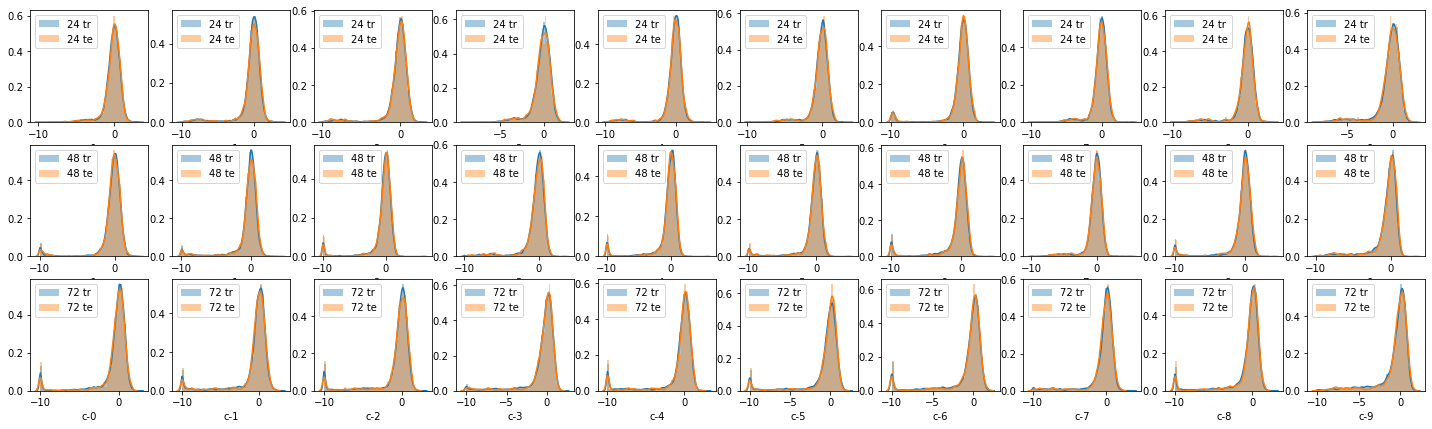

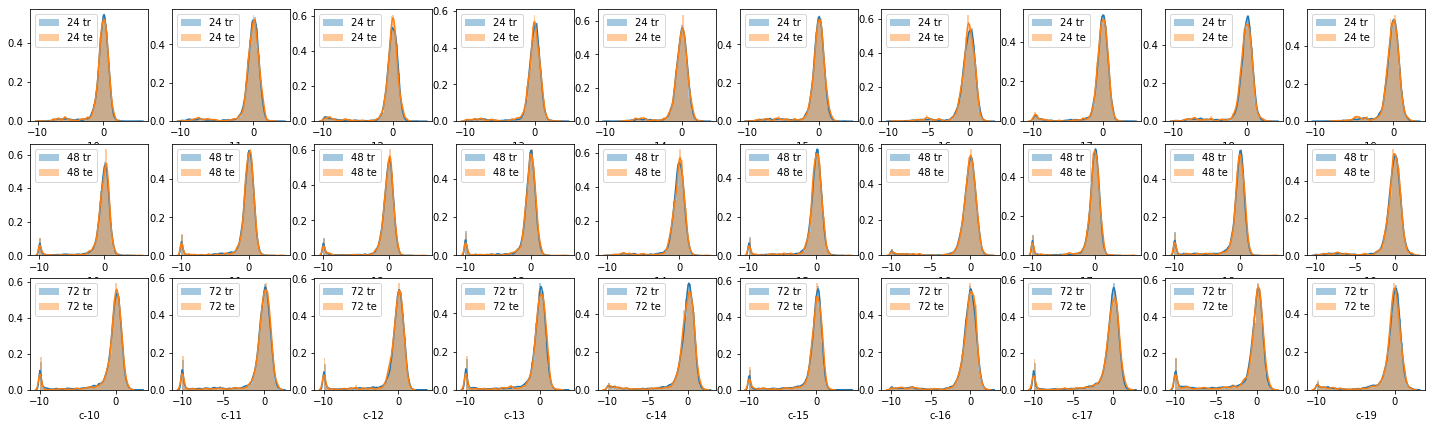

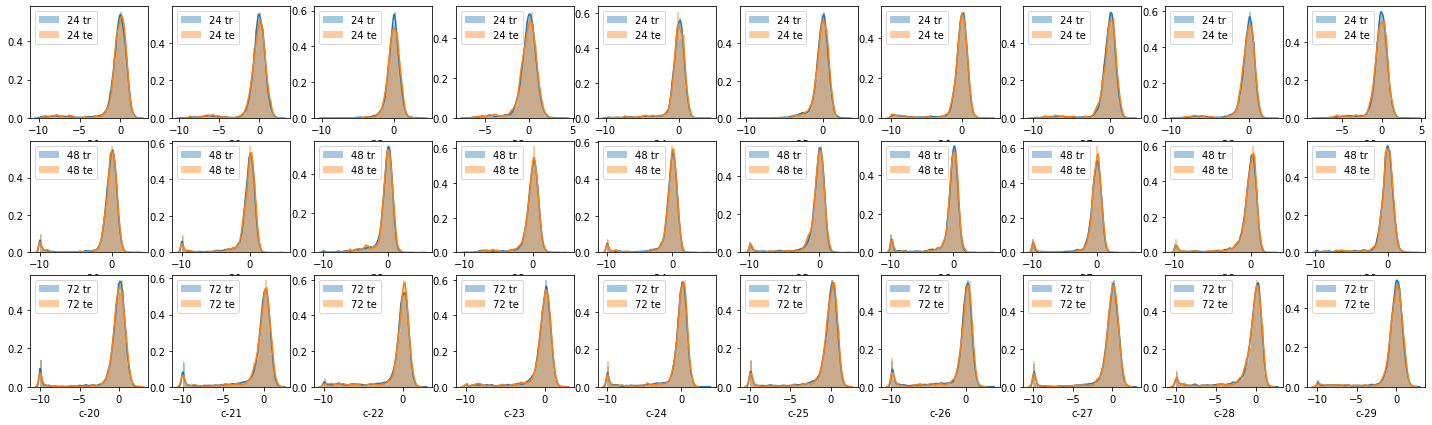

In [52]:
# "cp_time"
size = 10
for k in range(len(c_feats)//5//size + 1):
    plt.figure(figsize=(25,7))
    for ind, i in enumerate(range(size*k, size*(k+1))):
        if i <= len(c_feats)-1:
            plt.subplot(3,size,ind+1)
            sns.distplot(train_feat[train_feat.cp_time==24]["c-"+str(i)], label = "24 tr")
            sns.distplot(test_feat[test_feat.cp_time==24]["c-"+str(i)], label = "24 te")
            plt.legend(loc="best")
            plt.subplot(3,size,ind+1+size)
            sns.distplot(train_feat[train_feat.cp_time==48]["c-"+str(i)], label = "48 tr")
            sns.distplot(test_feat[test_feat.cp_time==48]["c-"+str(i)], label = "48 te")
            plt.legend(loc="best")
            plt.subplot(3,size,ind+1+2*size)
            sns.distplot(train_feat[train_feat.cp_time==72]["c-"+str(i)], label = "72 tr")
            sns.distplot(test_feat[test_feat.cp_time==72]["c-"+str(i)], label = "72 te")
            plt.legend(loc="best")

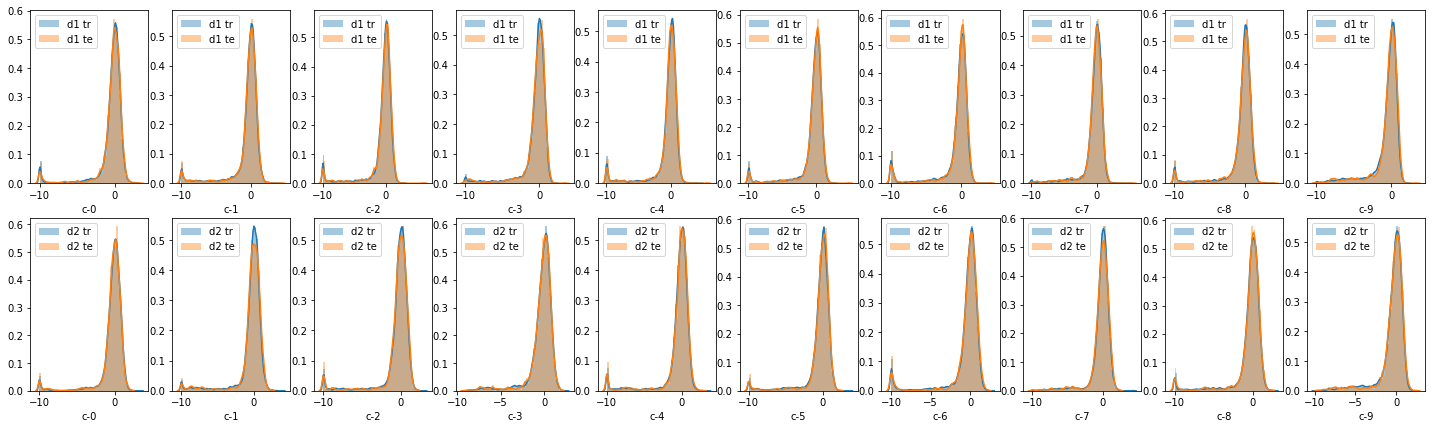

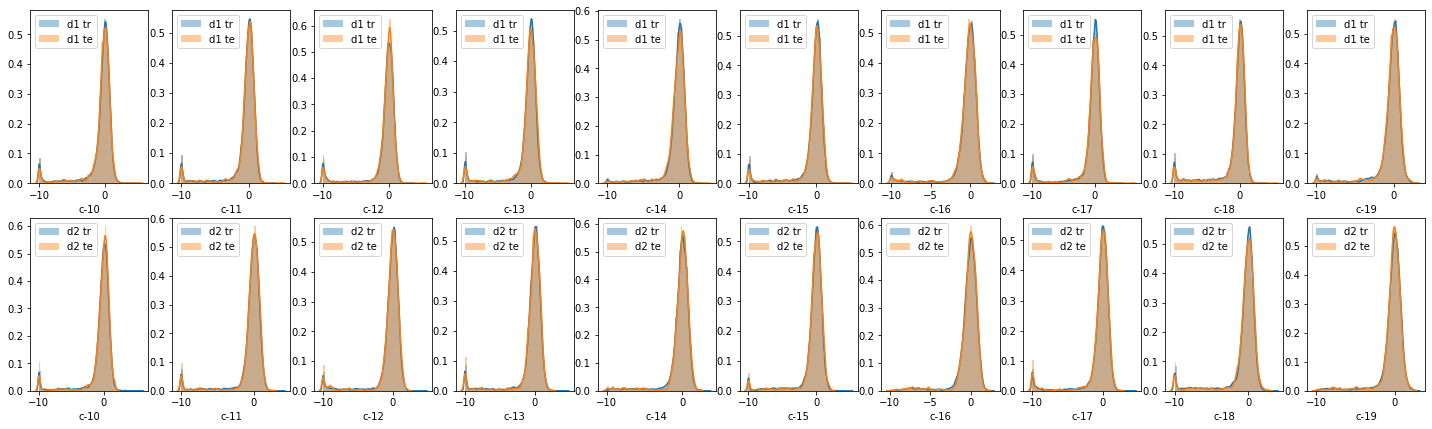

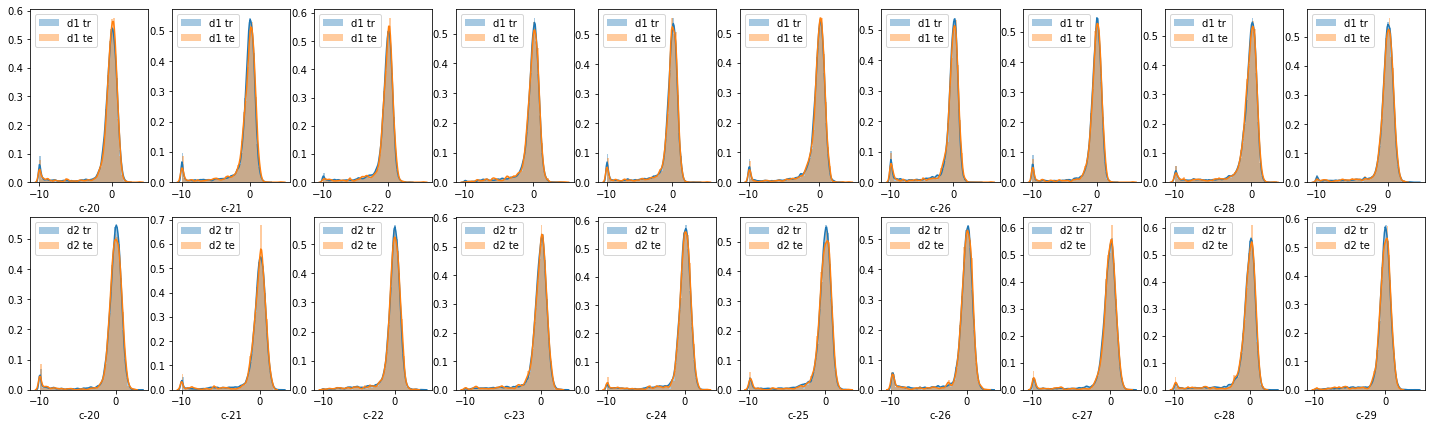

In [53]:
# "cp_dose"
size = 10
for k in range(len(c_feats)//5//size + 1):
    plt.figure(figsize=(25,7))
    for ind, i in enumerate(range(size*k, size*(k+1))):
        if i <= len(c_feats)-1:
            plt.subplot(2,size,ind+1)
            sns.distplot(train_feat[train_feat.cp_dose=="D1"]["c-"+str(i)], label = "d1 tr")
            sns.distplot(test_feat[test_feat.cp_dose=="D1"]["c-"+str(i)], label = "d1 te")
            plt.legend(loc="best")
            plt.subplot(2,size,ind+11)
            sns.distplot(train_feat[train_feat.cp_dose=="D2"]["c-"+str(i)], label = "d2 tr")
            sns.distplot(test_feat[test_feat.cp_dose=="D2"]["c-"+str(i)], label = "d2 te")
            plt.legend(loc="best")

# g-variables vs c-variables

In [54]:
a_feats = [i for i in train_feat.columns if i in c_feats or i in g_feats]
correlations = train_feat[a_feats].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'].isin(c_feats)]
correlations = correlations[correlations['level_1'].isin(g_feats)]
correlations.tail(20)

level_0 level_1         0
753865    c-70   g-731  0.838355
753885    c-72   g-349  0.838521
753910    c-73    g-38  0.838720
753915    c-90   g-349  0.838780
753980    c-75   g-328  0.839270
753992    c-42    g-38  0.839408
754196     c-2   g-349  0.841610
754221    c-83   g-349  0.841866
754225    c-13    g-38  0.841954
754313    c-75   g-349  0.842911
754319    c-93   g-349  0.842931
754381    c-38   g-349  0.843273
754401    c-17   g-349  0.843426
754462    c-94   g-349  0.844143
754497    c-38   g-228  0.844410
754615    c-42   g-349  0.845671
754654     c-6   g-349  0.846052
754659    c-62   g-349  0.846156
754989    c-31   g-349  0.849399
755045    c-60   g-349  0.850053

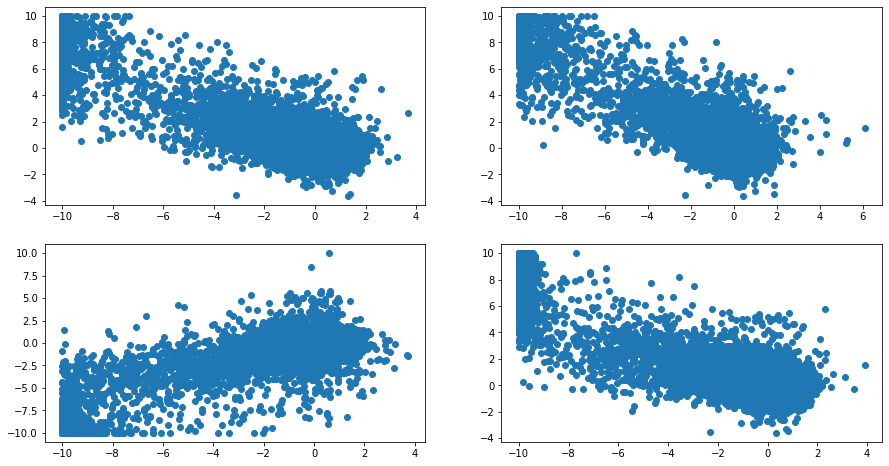

In [55]:
# some correlated examples
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.scatter(train_feat["c-60"], train_feat["g-349"])
plt.subplot(2,2,2)
plt.scatter(train_feat["c-31"], train_feat["g-349"])
plt.subplot(2,2,3)
plt.scatter(train_feat["c-38"], train_feat["g-228"])
plt.subplot(2,2,4)
plt.scatter(train_feat["c-6"], train_feat["g-349"])

# target info

In [56]:
target_feats = [i for i in train_score.columns if i != "sig_id"]
for i in target_feats:
    print(i, end=", ")

5-alpha_reductase_inhibitor, 11-beta-hsd1_inhibitor, acat_inhibitor, acetylcholine_receptor_agonist, acetylcholine_receptor_antagonist, acetylcholinesterase_inhibitor, adenosine_receptor_agonist, adenosine_receptor_antagonist, adenylyl_cyclase_activator, adrenergic_receptor_agonist, adrenergic_receptor_antagonist, akt_inhibitor, aldehyde_dehydrogenase_inhibitor, alk_inhibitor, ampk_activator, analgesic, androgen_receptor_agonist, androgen_receptor_antagonist, anesthetic_-_local, angiogenesis_inhibitor, angiotensin_receptor_antagonist, anti-inflammatory, antiarrhythmic, antibiotic, anticonvulsant, antifungal, antihistamine, antimalarial, antioxidant, antiprotozoal, antiviral, apoptosis_stimulant, aromatase_inhibitor, atm_kinase_inhibitor, atp-sensitive_potassium_channel_antagonist, atp_synthase_inhibitor, atpase_inhibitor, atr_kinase_inhibitor, aurora_kinase_inhibitor, autotaxin_inhibitor, bacterial_30s_ribosomal_subunit_inhibitor, bacterial_50s_ribosomal_subunit_inhibitor, bacterial_an

## per column

In [57]:
target_dists = pd.DataFrame(np.sum(train_score[target_feats])).reset_index(drop=False)
target_dists.columns = ["target", "number"]
target_dists.sort_values("number", ascending=False).reset_index(drop=True)

target  number
0                                nfkb_inhibitor     832
1                          proteasome_inhibitor     726
2                      cyclooxygenase_inhibitor     435
3                  dopamine_receptor_antagonist     424
4                 serotonin_receptor_antagonist     404
..                                          ...     ...
201                          elastase_inhibitor       6
202                                     steroid       6
203                        atm_kinase_inhibitor       6
204                             erbb2_inhibitor       1
205  atp-sensitive_potassium_channel_antagonist       1

[206 rows x 2 columns]

In [58]:
target_dists["number"].describe() # ターゲットラベルとしてあるのに、一回も観測されていないターゲットはない

count    206.000000
mean      81.766990
std      115.160351
min        1.000000
25%       19.000000
50%       38.500000
75%       83.000000
max      832.000000
Name: number, dtype: float64

<BarContainer object of 206 artists>

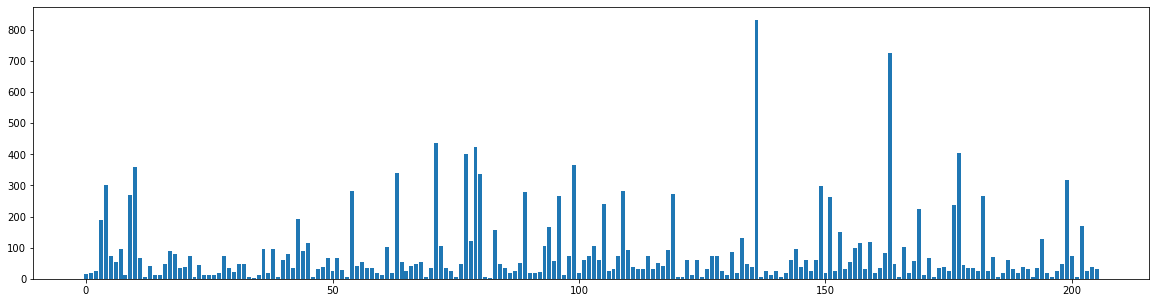

In [59]:
# prediction difficult differs per target 
plt.figure(figsize=(20,5))
plt.bar(range(target_dists.shape[0]), target_dists["number"])

In [60]:
target_dists["suffix"] = target_dists["target"].apply(lambda x: x.split("_")[-1])
target_dists["suffix"].value_counts(sort=True, normalize=True).reset_index(drop=False).head(10)

index    suffix
0   inhibitor  0.543689
1  antagonist  0.155340
2     agonist  0.135922
3   activator  0.024272
4       agent  0.014563
5     blocker  0.009709
6  antifolate  0.004854
7   stimulant  0.004854
8  antifungal  0.004854
9     steroid  0.004854

[]

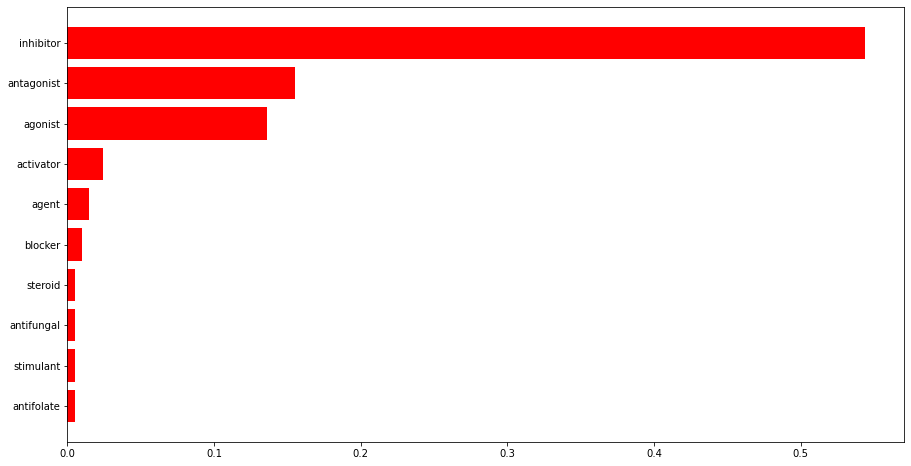

In [61]:
tmp = pd.DataFrame(target_dists["suffix"].value_counts(sort=True, normalize=True).reset_index(drop=False)).head(10)
tmp = tmp.sort_values("suffix", ascending=True).reset_index(drop=True)
plt.figure(figsize=(15,8))
plt.barh(range(tmp.shape[0]),tmp["suffix"], color="r")
plt.yticks(range(tmp.shape[0]), tmp["index"], rotation='horizontal')
plt.plot()

In [62]:
target_dists.groupby("suffix")["number"].sum()

suffix
activator             115
agent                 150
agonist              2330
analgesic              12
antagonist           3449
anti-inflammatory      73
antiarrhythmic          6
antibiotic             43
anticonvulsant         12
antifolate             36
antifungal             13
antihistamine          12
antimalarial           18
antioxidant            73
antiprotozoal          36
antiviral              23
b                      26
blocker               323
diuretic                6
donor                  26
immunosuppressant      73
inhibitor            9693
laxative                6
local                  80
medium                 56
scavenger              18
secretagogue           30
sensitizer             51
steroid                 6
stimulant              49
Name: number, dtype: int64

[]

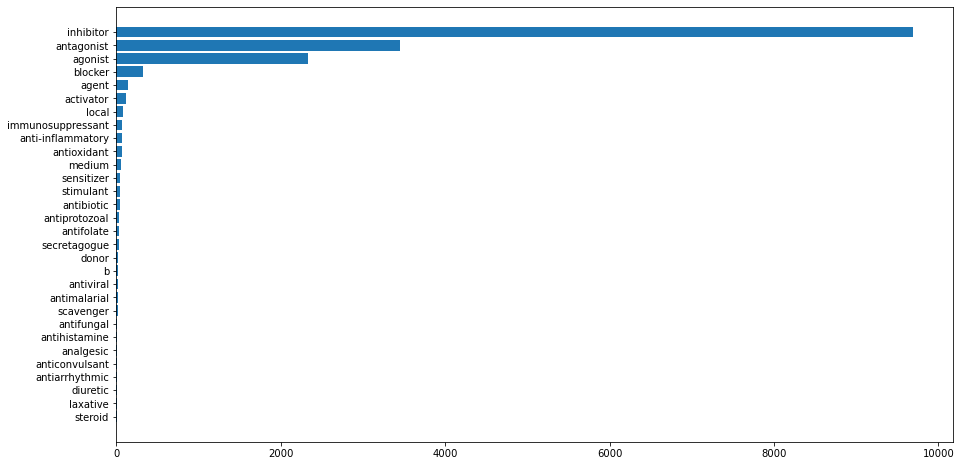

In [63]:
tmp = pd.DataFrame(target_dists.groupby("suffix")["number"].sum()).reset_index(drop=False)
tmp = tmp.sort_values("number", ascending=True).reset_index(drop=True)
plt.figure(figsize=(15,8))
plt.barh(range(tmp.shape[0]),tmp["number"])
plt.yticks(range(tmp.shape[0]), tmp["suffix"], rotation='horizontal')
plt.plot()

## per row

16844
1    12532
0     7501
2     1538
3      303
4       55
5       13
7        6
Name: score_sum, dtype: int64


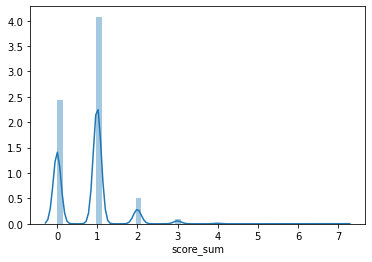

In [64]:
train_score["score_sum"] = pd.DataFrame(np.sum(train_score[target_feats], axis=1))
print(train_score["score_sum"].sum())
print(train_score["score_sum"].value_counts())
sns.distplot(train_score["score_sum"])

In [65]:
# positive label rate = 0.3%
train_score["score_sum"].sum() * 100 / (len(target_feats) * train_feat.shape[0])

0.3725487073594958

## correlations in target variables

In [66]:
correlations = train_score[target_feats].corr().abs()
correlations = (correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
correlations.tail(20)

atp-sensitive_potassium_channel_antagonist  laxative                                      0.000112
calcineurin_inhibitor                       erbb2_inhibitor                               0.000112
erbb2_inhibitor                             leukotriene_inhibitor                         0.000112
antiarrhythmic                              erbb2_inhibitor                               0.000112
erbb2_inhibitor                             steroid                                       0.000112
atp-sensitive_potassium_channel_antagonist  coagulation_factor_inhibitor                  0.000112
                                            nicotinic_receptor_agonist                    0.000112
atm_kinase_inhibitor                        atp-sensitive_potassium_channel_antagonist    0.000112
atp-sensitive_potassium_channel_antagonist  lxr_agonist                                   0.000112
                                            protein_phosphatase_inhibitor                 0.000112
          

In [67]:
correlations[correlations>0.5].shape

(5,)

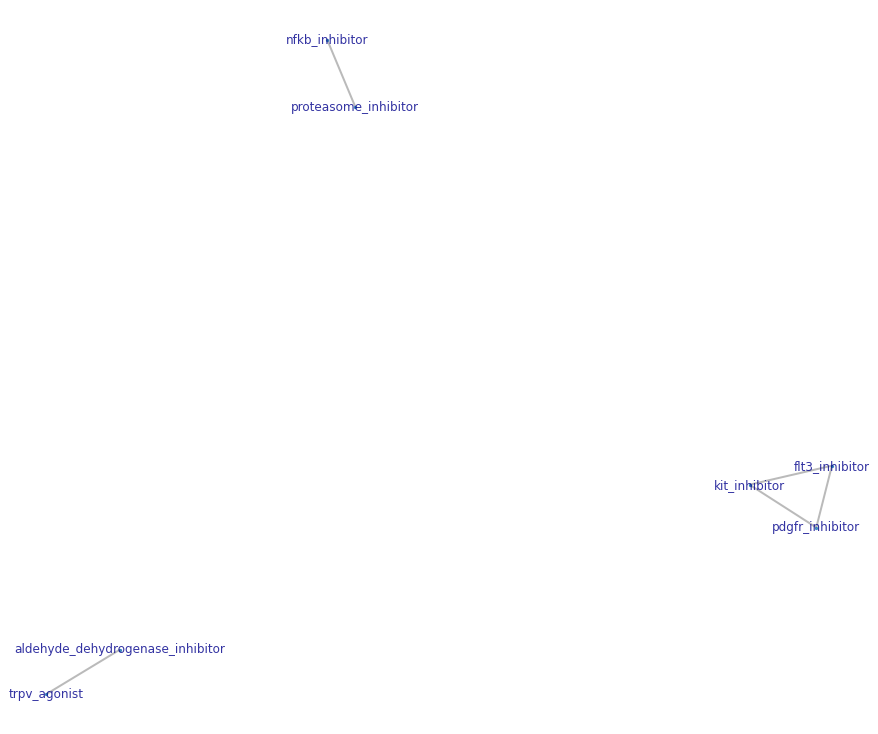

In [68]:
# https://www.kaggle.com/jpmiller/finding-patterns-in-the-scored-targets
import networkx as nx

pairs_df = (1-correlations).reset_index()
G = nx.from_pandas_edgelist(pairs_df[:5], source='level_0', target='level_1', edge_attr=0)

graph_opts = dict(arrows=False,
                  node_size=5,
                  width=2,
                  alpha=0.8,
                  font_size=12,
                  font_color='darkblue',
                  edge_color='darkgray'
                 )

fig= plt.figure(figsize=(12,10))
nx.draw_spring(G, with_labels=True, **graph_opts)

In [69]:
nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

[frozenset({'flt3_inhibitor', 'kit_inhibitor', 'pdgfr_inhibitor'}),
 frozenset({'nfkb_inhibitor', 'proteasome_inhibitor'}),
 frozenset({'aldehyde_dehydrogenase_inhibitor', 'trpv_agonist'})]

# auxiliary training data

In [70]:
cons_feats = [i for i in train_nonscore.columns if i != "sig_id"]

In [71]:
correlations = train_nonscore[cons_feats].corr().abs()
correlations = (correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
correlations.tail(20)

antiseptic                                 fungal_ergosterol_inhibitor                  0.000112
                                           tryptophan_hydroxylase_inhibitor             0.000112
farnesyl_pyrophosphate_synthase_inhibitor  srebp_inhibitor                              0.000102
                                           mrp_inhibitor                                0.000102
growth_factor_receptor_inhibitor           srebp_inhibitor                              0.000102
                                           mrp_inhibitor                                0.000102
hemoglobin_antagonist                      srebp_inhibitor                              0.000102
                                           mrp_inhibitor                                0.000102
antiseptic                                 srebp_inhibitor                              0.000102
                                           mrp_inhibitor                                0.000102
adenosine_kinase_inhibitor    

In [72]:
correlations[correlations>0.5].shape

(34,)

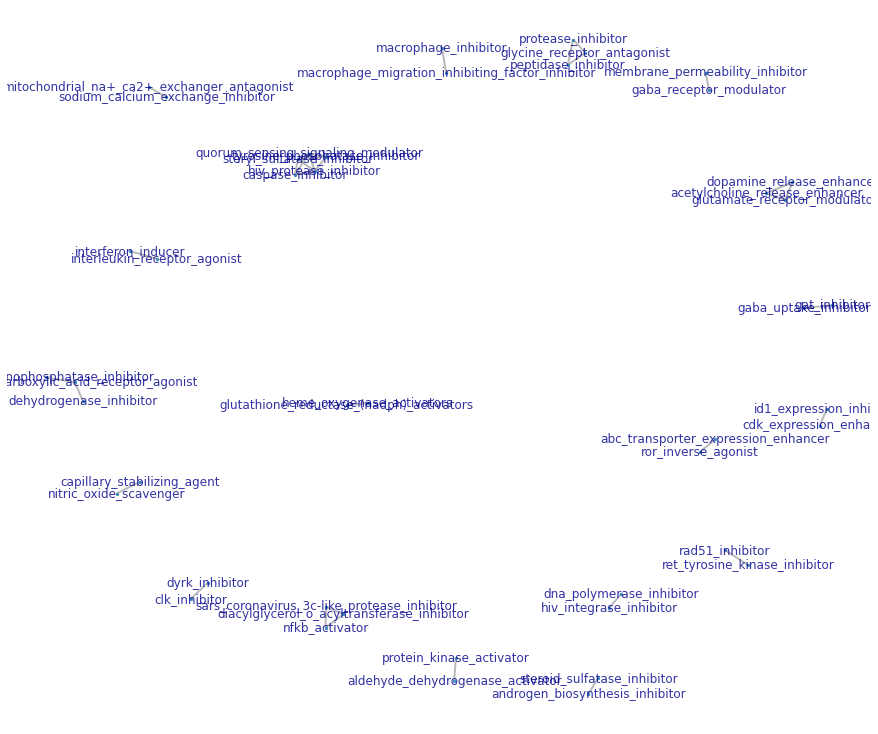

In [73]:
# https://www.kaggle.com/jpmiller/finding-patterns-in-the-scored-targets
import networkx as nx

pairs_df = (correlations).reset_index()
G = nx.from_pandas_edgelist(pairs_df[:34], source='level_0', target='level_1', edge_attr=0)

graph_opts = dict(arrows=False,
                  node_size=5,
                  width=2,
                  alpha=0.8,
                  font_size=12,
                  font_color='darkblue',
                  edge_color='darkgray'
                 )

fig= plt.figure(figsize=(12,10))
nx.draw_spring(G, with_labels=True, **graph_opts)

In [74]:
nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

[frozenset({'caspase_inhibitor',
            'hiv_protease_inhibitor',
            'quorum_sensing_signaling_modulator',
            'steryl_sulfatase_inhibitor',
            'tyrosine_phosphatase_inhibitor'}),
 frozenset({'acetylcholine_release_enhancer',
            'dopamine_release_enhancer',
            'glutamate_receptor_modulator'}),
 frozenset({'diacylglycerol_o_acyltransferase_inhibitor',
            'nfkb_activator',
            'sars_coronavirus_3c-like_protease_inhibitor'}),
 frozenset({'glycine_receptor_antagonist',
            'peptidase_inhibitor',
            'protease_inhibitor'}),
 frozenset({'dehydrogenase_inhibitor',
            'hydroxycarboxylic_acid_receptor_agonist',
            'inositol_monophosphatase_inhibitor'}),
 frozenset({'dna_polymerase_inhibitor', 'hiv_integrase_inhibitor'}),
 frozenset({'rad51_inhibitor', 'ret_tyrosine_kinase_inhibitor'}),
 frozenset({'mitochondrial_na+_ca2+_exchanger_antagonist',
            'sodium_calcium_exchange_inhibitor'}),
 f

In [75]:
set(train_nonscore.sig_id.unique()) == set(train_score.sig_id.unique()) # idは完全一致

True

In [76]:
set(train_score.columns) & set(train_nonscore.columns) # id以外の変数はscore.csvとnon-score.csvで異なる

{'sig_id'}

## per column

In [77]:
nontarget_dists = pd.DataFrame(np.sum(train_nonscore[cons_feats])).reset_index(drop=False)
nontarget_dists.columns = ["target", "number"]
nontarget_dists = nontarget_dists.sort_values("number", ascending=False).reset_index(drop=True)

In [78]:
len(cons_feats)

402

In [79]:
print(nontarget_dists[nontarget_dists.number==0].shape)
print(nontarget_dists[nontarget_dists.number==1].shape)
print(nontarget_dists[nontarget_dists.number==2].shape)
print(nontarget_dists[nontarget_dists.number==3].shape)
print(nontarget_dists[nontarget_dists.number==4].shape)
print(nontarget_dists[nontarget_dists.number==5].shape)
print(nontarget_dists[nontarget_dists.number==6].shape)

(71, 2)
(4, 2)
(1, 2)
(0, 2)
(0, 2)
(2, 2)
(119, 2)


In [80]:
np.transpose(nontarget_dists.tail(200))

202                                      203  \
target  contrast_agent  fungal_lanosterol_demethylase_inhibitor   
number               7                                        7   

                                             204  \
target  carnitine_palmitoyltransferase_inhibitor   
number                                         7   

                                 205                                     206  \
target  omega_3_fatty_acid_stimulant  ubiquitin-conjugating_enzyme_inhibitor   
number                             6                                       6   

                   207                               208              209  \
target  bronchodilator  tryptophan_hydroxylase_inhibitor  vasoconstrictor   
number               6                                 6                6   

                                    210                     211  \
target  androgen_biosynthesis_inhibitor  ve-cadherin_antagonist   
number                                6                       6   

                                   212                  213             214  \
target  tyrosine_hydroxylase_inhibitor  porcupine_inhibitor  ampk_inhibitor   
number                               6                    6               6   

                                         215                  216  \
target  penicillin_binding_protein_inhibitor  peptidase_inhibitor   
number                                     6                    6   

                                   217                         218  \
target  acetylcholine_release_enhancer  adenylyl_cyclase_inhibitor   
number                               6                           6   

                      219        220                               221  \
target  uricase_inhibitor  bile_acid  aldehyde_dehydrogenase_activator   
number                  6          6                                 6   

                  222            223                           224  \
target  pka_inhibitor  p53_inhibitor  botulin_neurotoxin_inhibitor   
number              6              6                             6   

                                   225                      226  \
target  wdr5_mll_interaction_inhibitor  phospholipase_activator   
number                               6                        6   

                  227                               228  \
target  antispasmodic  triacylglycerol_lipase_inhibitor   
number              6                                 6   

                                229                              230  \
target  aspartic_protease_inhibitor  thrombopoietin_receptor_agonist   
number                            6                                6   

                                     231                   232           233  \
target  testosterone_receptor_antagonist  telomerase_inhibitor  antipruritic   
number                                 6                     6             6   

                     234                          235           236  \
target  t_cell_inhibitor  serotonin_release_inhibitor  ap_inhibitor   
number                 6                            6             6   

               237                          238  \
target  anxiolytic  smoothened_receptor_agonist   
number           6                            6   

                                      239                                 240  \
target  sodium_calcium_exchange_inhibitor  structural_glycoprotein_antagonist   
number                                  6                                   6   

                             241                     242  \
target  sodium_channel_activator  sodium_channel_blocker   
number                         6                       6   

                               243                 244                  245  \
target  steryl_sulfatase_inhibitor  antirheumatic_drug  ror_inverse_agonist   
number                           6                   6                    6   

                         

In [81]:
nontarget_dists["suffix"] = nontarget_dists["target"].apply(lambda x: x.split("_")[-1])
nontarget_dists["suffix"].value_counts(sort=True, normalize=True).reset_index(drop=False).head(10)

index    suffix
0   inhibitor  0.524876
1  antagonist  0.109453
2     agonist  0.089552
3   activator  0.054726
4       agent  0.032338
5   stimulant  0.019900
6    enhancer  0.014925
7     inducer  0.014925
8     blocker  0.012438
9   modulator  0.012438

[]

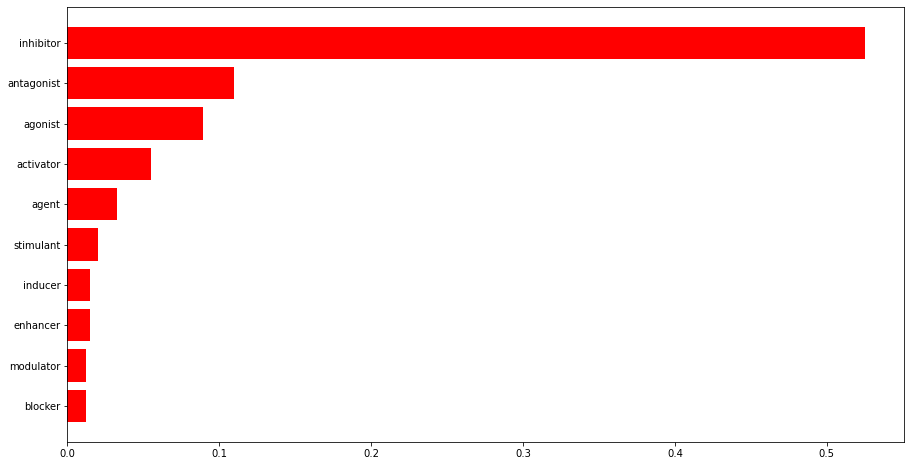

In [82]:
tmp = pd.DataFrame(nontarget_dists["suffix"].value_counts(sort=True, normalize=True).reset_index(drop=False)).head(10)
tmp = tmp.sort_values("suffix", ascending=True).reset_index(drop=True)
plt.figure(figsize=(15,8))
plt.barh(range(tmp.shape[0]),tmp["suffix"], color="r")
plt.yticks(range(tmp.shape[0]), tmp["index"], rotation='horizontal')
plt.plot()

In [83]:
nontarget_dists.groupby("suffix")["number"].sum()

suffix
(serm)                30
(ssri)                36
acid                   6
activator            190
activators            12
agent                153
agonist              404
analog                13
anesthetic             0
antacid               12
antagonist           562
anthelmintic          24
antidepressant        30
antiepileptic         24
antihypertensive       0
antimetabolite         0
antipruritic           6
antiseptic             1
antispasmodic          6
antitussive           30
anxiolytic             6
blocker               48
bronchodilator         6
carcinogen            42
diuretic              19
drug                  24
enhancer              24
estrogen               0
glycoside              0
hormone               29
immunostimulant       36
inducer               66
inhibitor           2876
k                      6
ligand                24
modulator             59
mucolytic              0
neurotransmitter       6
precursor             12
progestin         

[]

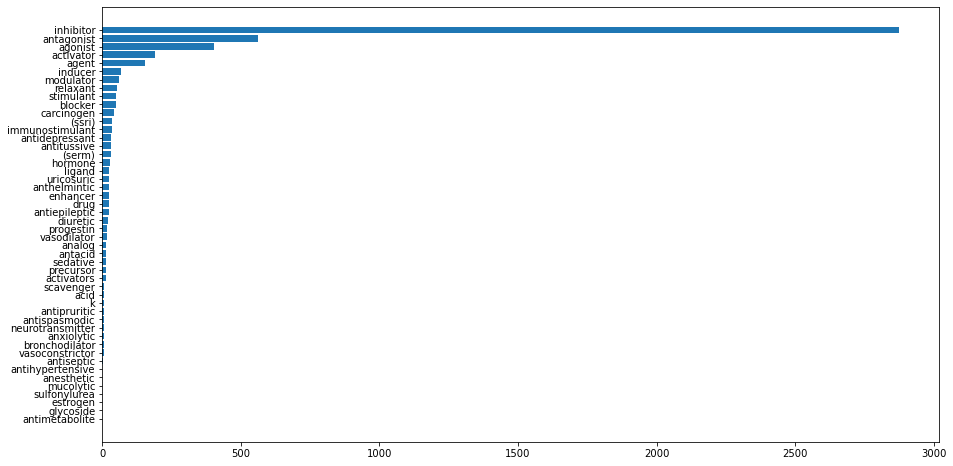

In [84]:
tmp = pd.DataFrame(nontarget_dists.groupby("suffix")["number"].sum()).reset_index(drop=False)
tmp = tmp.sort_values("number", ascending=True).reset_index(drop=True)
plt.figure(figsize=(15,8))
plt.barh(range(tmp.shape[0]),tmp["number"])
plt.yticks(range(tmp.shape[0]), tmp["suffix"], rotation='horizontal')
plt.plot()

In [85]:
nontarget_dists.describe()

number
count  402.000000
mean    12.457711
std     13.359389
min      0.000000
25%      6.000000
50%      7.000000
75%     18.000000
max     91.000000

[]

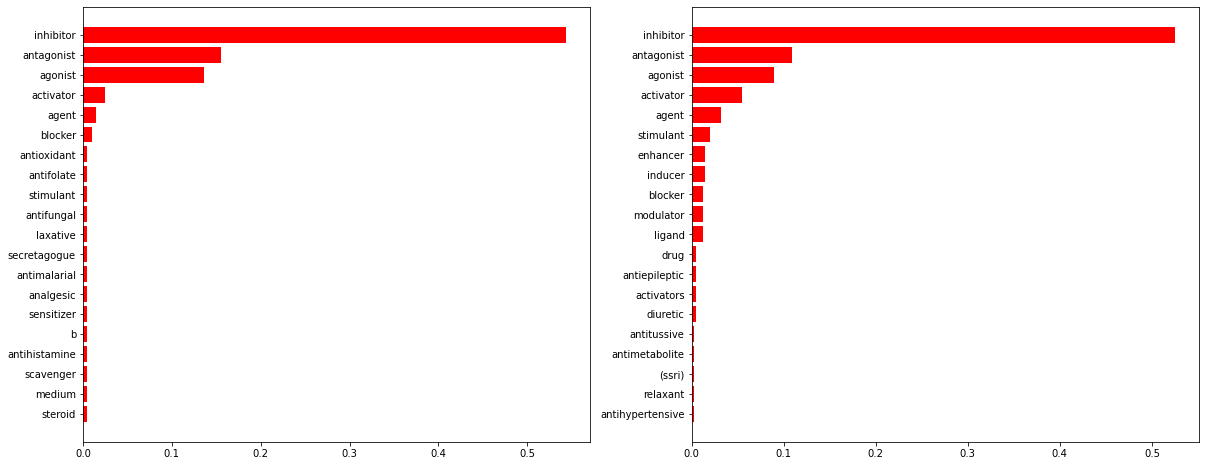

In [86]:
# comparison of ratio of suffix
tmp1 = pd.DataFrame(target_dists["suffix"].value_counts(sort=True, normalize=True).reset_index(drop=False)).head(20)
tmp1 = tmp1.sort_values("suffix", ascending=True).reset_index(drop=True)

tmp2 = pd.DataFrame(nontarget_dists["suffix"].value_counts(sort=True, normalize=True).reset_index(drop=False)).head(20)
tmp2 = tmp2.sort_values("suffix", ascending=True).reset_index(drop=True)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.barh(range(tmp1.shape[0]),tmp1["suffix"],color="red")
plt.yticks(range(tmp1.shape[0]), tmp1["index"], rotation='horizontal')
plt.plot()
plt.subplot(1,2,2)
plt.barh(range(tmp2.shape[0]),tmp2["suffix"],color="red")
plt.yticks(range(tmp2.shape[0]), tmp2["index"], rotation='horizontal')
plt.plot()

[]

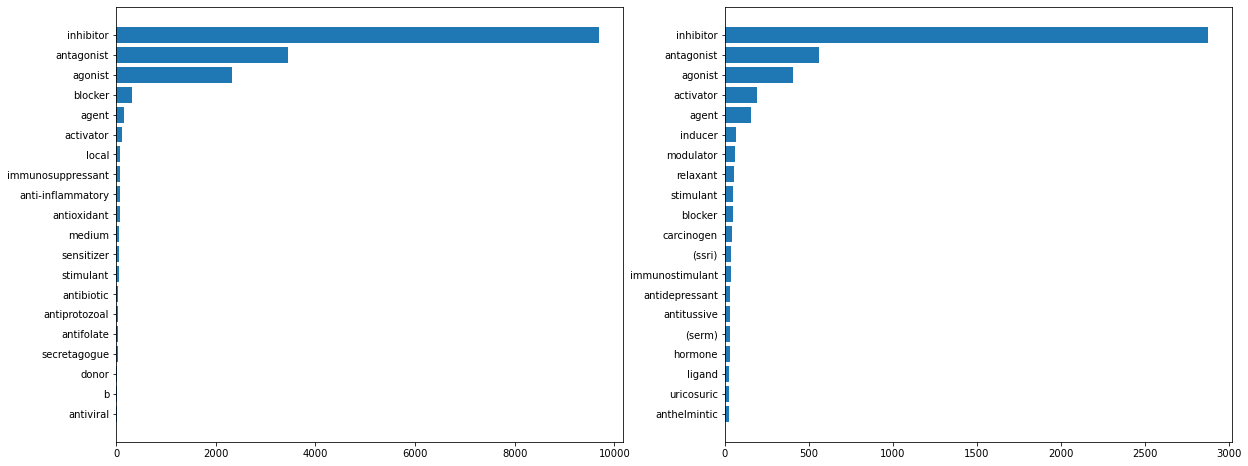

In [87]:
# comparison of sum of suffix
tmp1 = pd.DataFrame(target_dists.groupby("suffix")["number"].sum()).reset_index(drop=False)
tmp1 = tmp1.sort_values("number", ascending=True).reset_index(drop=True).tail(20)

tmp2 = pd.DataFrame(nontarget_dists.groupby("suffix")["number"].sum()).reset_index(drop=False)
tmp2 = tmp2.sort_values("number", ascending=True).reset_index(drop=True).tail(20)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.barh(range(tmp1.shape[0]),tmp1["number"])
plt.yticks(range(tmp1.shape[0]), tmp1["suffix"], rotation='horizontal')
plt.plot()
plt.subplot(1,2,2)
plt.barh(range(tmp2.shape[0]),tmp2["number"])
plt.yticks(range(tmp2.shape[0]), tmp2["suffix"], rotation='horizontal')
plt.plot()

## per row

5008
0    17358
1     4282
2      247
3       36
4       13
7        6
5        6
Name: nonscore_sum, dtype: int64


(array([1.7358e+04, 4.2820e+03, 2.4700e+02, 0.0000e+00, 3.6000e+01,
        1.3000e+01, 0.0000e+00, 6.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

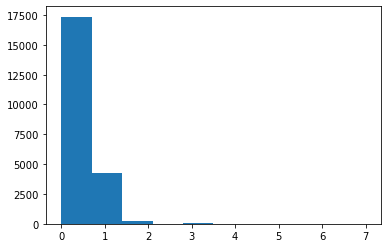

In [88]:
train_nonscore["nonscore_sum"] = pd.DataFrame(np.sum(train_nonscore[cons_feats], axis=1))
print(train_nonscore["nonscore_sum"].sum())
print(train_nonscore["nonscore_sum"].value_counts())
plt.hist(train_nonscore["nonscore_sum"])

In [89]:
train_nonscore["nonscore_sum"].sum() * 100 / (len(cons_feats) * train_nonscore.shape[0])

0.056760121390496035

In [90]:
all_moa_info = pd.merge(train_score, train_nonscore, on="sig_id", how="outer")

In [91]:
all_moa_info[["score_sum","nonscore_sum"]].corr() # weak negative correlation

score_sum  nonscore_sum
score_sum      1.000000     -0.308418
nonscore_sum  -0.308418      1.000000

In [92]:
pd.crosstab(all_moa_info["score_sum"], all_moa_info["nonscore_sum"])

nonscore_sum      0     1    2   3  4  5  7
score_sum                                  
0              3664  3680  150   6  1  0  0
1             11956   479   79  12  6  0  0
2              1428    86   12   0  6  6  0
3               279    18    6   0  0  0  0
4                31     6    0  12  0  0  6
5                 0    13    0   0  0  0  0
7                 0     0    0   6  0  0  0

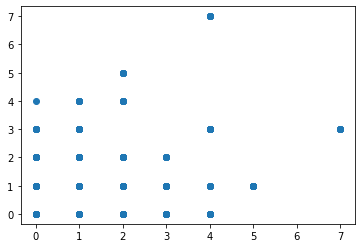

In [93]:
plt.scatter(all_moa_info[["score_sum"]], all_moa_info[["nonscore_sum"]])

# combined training data

In [94]:
def std_calc(row):
    return np.std(row[g_feats])

def mean_calc(row):
    return np.mean(row[g_feats])

tqdm_notebook.pandas(desc="progress")
train_feat[["g_std"]] = train_feat.progress_apply(std_calc, axis=1)
test_feat[["g_std"]] = test_feat.progress_apply(std_calc, axis=1)
train_feat[["g_mean"]] = train_feat.progress_apply(mean_calc, axis=1)
test_feat[["g_mean"]] = test_feat.progress_apply(mean_calc, axis=1)
#print("train", np.max(train_feat["g_unique_num"]), np.min(train_feat["g_unique_num"]))
#print("test ", np.max(test_feat["g_unique_num"]), np.min(test_feat["g_unique_num"]))

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [95]:
def std_calc(row):
    return np.std(row[c_feats])

def mean_calc(row):
    return np.mean(row[c_feats])

tqdm_notebook.pandas(desc="progress")
train_feat[["c_std"]] = train_feat.progress_apply(std_calc, axis=1)
test_feat[["c_std"]] = test_feat.progress_apply(std_calc, axis=1)
train_feat[["c_mean"]] = train_feat.progress_apply(mean_calc, axis=1)
test_feat[["c_mean"]] = test_feat.progress_apply(mean_calc, axis=1)

In [96]:
train = pd.merge(train_feat, train_score, on="sig_id")
train["target_sum"] = train[target_feats].sum(axis=1)
print(train.shape)

(21948, 1092)


In [97]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
0 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
1  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
2 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
3  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
4  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   

     g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
0 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360   
1  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646   
2 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181   
3 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580   
4  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685   

     g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30  \
0 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934   
1 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499   
2 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530   
3 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575   
4  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712   

     g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39  \
0 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
1 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
2  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
3  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
4  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

     g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48  \
0 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350   
1  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710   
2  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983   
3 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851   
4  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780   

     g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57  \
0  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263   
1 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759   
2  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621   
3  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331   
4 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130   

     g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66  \
0  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670   
1  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026   
2 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292   
3  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314   
4  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000   

     g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75  \
0 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332   
1  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857   
2  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570   
3  

In [98]:
# it's confirmed that control perturbations have no MoAs
train[train.cp_type=="ctl_vehicle"][target_feats].sum().sum()

0

In [99]:
# target variables vs explanation variables
all_feats = [i for i in train.columns if i != "sig_id"]
correlations = train[all_feats].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'].isin(target_feats)]
correlations = correlations[~correlations['level_1'].isin(target_feats)].reset_index(drop=True)
correlations.tail(20)

level_0 level_1         0
181878  proteasome_inhibitor    c-14  0.767815
181879  proteasome_inhibitor    c-68  0.770052
181880  proteasome_inhibitor    c-27  0.772269
181881  proteasome_inhibitor    c-61  0.772351
181882  proteasome_inhibitor    c-72  0.772406
181883  proteasome_inhibitor    c-90  0.774141
181884  proteasome_inhibitor    c-17  0.778975
181885  proteasome_inhibitor    c-93  0.780356
181886  proteasome_inhibitor    c-35  0.782141
181887  proteasome_inhibitor    c-44  0.782305
181888  proteasome_inhibitor  c_mean  0.782991
181889  proteasome_inhibitor    c-88  0.783706
181890  proteasome_inhibitor    c-85  0.784811
181891  proteasome_inhibitor    c-83  0.787470
181892  proteasome_inhibitor    c-16  0.789159
181893  proteasome_inhibitor   g-349  0.789331
181894  proteasome_inhibitor    c-31  0.798461
181895  proteasome_inhibitor    c-53  0.798831
181896  proteasome_inhibitor    c-32  0.804192
181897  proteasome_inhibitor    c-78  0.819816

In [100]:
correlations.head(20)

level_0 level_1             0
0                  beta_amyloid_inhibitor   g-217  3.928972e-08
1                          acat_inhibitor   g-255  1.142334e-07
2         benzodiazepine_receptor_agonist   g-481  3.948857e-07
3                  beta_amyloid_inhibitor   g-345  4.094129e-07
4                           hcv_inhibitor   g-373  4.442083e-07
5                 cck_receptor_antagonist   g-253  4.911229e-07
6                           antihistamine    g-23  5.000695e-07
7                    insulin_secretagogue   g-251  5.217303e-07
8             potassium_channel_activator   g-649  5.558960e-07
9                               analgesic    c-58  5.720282e-07
10       progesterone_receptor_antagonist   g-765  5.808323e-07
11                    apoptosis_stimulant   g-536  7.234841e-07
12                              analgesic   g-383  7.659585e-07
13                          antihistamine   g-584  8.081027e-07
14                               diuretic    g-13  8.622598e-07
15  ubiquitin_specific_protease_inhibitor   g-455  9.422703e-07
16                             antifungal   c_std  9.688365e-07
17                         acat_inhibitor    g-87  1.010965e-06
18           serotonin_reuptake_inhibitor    g-85  1.249700e-06
19           cannabinoid_receptor_agonist   g-530  1.279710e-06

# all targets

In [101]:
all_targets = pd.merge(train_score, train_nonscore, on="sig_id", how="outer")
print(all_targets.shape)

(21948, 611)


In [102]:
all_feats = [i for i in all_targets.columns if i != "sig_id"]
correlations = all_targets[all_feats].corr().abs()
correlations = (correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))

In [103]:
correlations[correlations>0.4].shape

(99,)

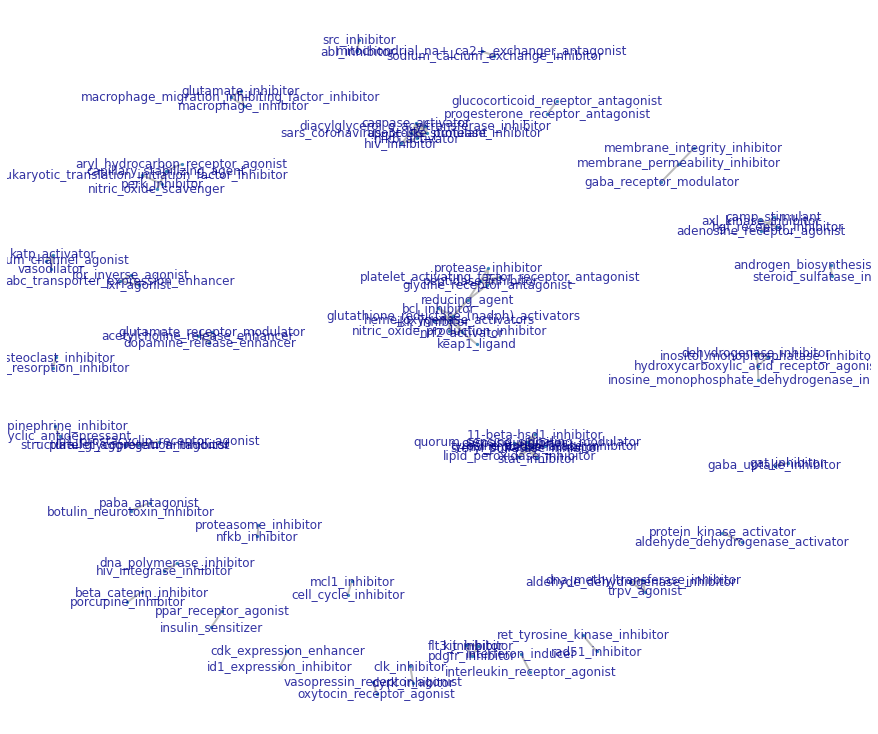

In [104]:
# https://www.kaggle.com/jpmiller/finding-patterns-in-the-scored-targets
import networkx as nx

pairs_df = (correlations).reset_index()
G = nx.from_pandas_edgelist(pairs_df[:99], source='level_0', target='level_1', edge_attr=0)

graph_opts = dict(arrows=False,
                  node_size=5,
                  width=2,
                  alpha=0.8,
                  font_size=12,
                  font_color='darkblue',
                  edge_color='darkgray'
                 )

fig= plt.figure(figsize=(12,10))
nx.draw_spring(G, with_labels=True, **graph_opts)

In [105]:
nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

[frozenset({'bcl_inhibitor',
            'glutathione_reductase_(nadph)_activators',
            'glycine_receptor_antagonist',
            'heme_oxygenase_activators',
            'ikk_inhibitor',
            'keap1_ligand',
            'nitric_oxide_production_inhibitor',
            'nrf2_activator',
            'peptidase_inhibitor',
            'platelet_activating_factor_receptor_antagonist',
            'protease_inhibitor',
            'reducing_agent'}),
 frozenset({'11-beta-hsd1_inhibitor',
            'caspase_inhibitor',
            'hiv_protease_inhibitor',
            'lipid_peroxidase_inhibitor',
            'quorum_sensing_signaling_modulator',
            'stat_inhibitor',
            'steryl_sulfatase_inhibitor',
            'tyrosine_phosphatase_inhibitor'}),
 frozenset({'apoptosis_stimulant',
            'caspase_activator',
            'diacylglycerol_o_acyltransferase_inhibitor',
            'hiv_inhibitor',
            'nfkb_activator',
            'sars_coronavi

# can we predict sum of moa?

In [106]:
from sklearn import preprocessing
categoricals = ["cp_type", "cp_dose"]

def encoding(tr, te):
    for f in categoricals:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(tr[f]))
        tr[f] = lbl.transform(list(tr[f]))
        te[f] = lbl.transform(list(te[f])) 
        
    return tr, te

train_feat, test_feat = encoding(train_feat, test_feat)

In [107]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
def modelling_lgb(new_train, target_train, new_test, target):
    
    X_train = new_train.copy() #.drop("sig_id", axis=1)

    y_train = target_train[target].copy()
    
    params = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'tree_learner': 'serial', 'learning_rate': 0.01, 
               "num_leaves": 10, 'random_seed':44, 'max_depth': 4} 
        
    n_folds=4
    skf=StratifiedKFold(n_splits = n_folds, shuffle=True, random_state=0)
    
    valid = np.zeros([X_train.shape[0]])
    for i , (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train2 = X_train.iloc[train_index,:]
        y_train2 = y_train.iloc[train_index]

        X_valid2 = X_train.iloc[test_index,:]
        y_valid2 = y_train.iloc[test_index]
        
        lgb_train = lgb.Dataset(X_train2, y_train2)
        lgb_eval = lgb.Dataset(X_valid2, y_valid2, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train,valid_sets=[lgb_train, lgb_eval], 
               num_boost_round=10000,early_stopping_rounds=50,verbose_eval = 100) 

        valid_predict = clf.predict(X_valid2, num_iteration = clf.best_iteration)
        valid[test_index] = valid_predict
            
    score = mean_squared_error(y_train, valid)
    print(score)
            
    return valid

valid = modelling_lgb(train_feat, train_score, test_feat, "score_sum")

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: sig_id

In [108]:
import optuna

def optuna_check(new_train, target_train, target, params):
    
    X_train = new_train.copy() #.drop(['sig_id'],axis=1).copy()
    y_train = target_train[target].copy()
        
    n_folds=4
    skf=StratifiedKFold(n_splits = n_folds, shuffle=True, random_state=0)

    valid = np.zeros([X_train.shape[0]])
    for i , (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        print("Fold "+str(i+1))
        X_train2 = X_train.iloc[train_index,:]
        y_train2 = y_train.iloc[train_index]

        X_valid2 = X_train.iloc[test_index,:]
        y_valid2 = y_train.iloc[test_index]
        
        lgb_train = lgb.Dataset(X_train2, y_train2)
        lgb_eval = lgb.Dataset(X_valid2, y_valid2, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train,valid_sets=[lgb_train, lgb_eval], 
               num_boost_round=10000,early_stopping_rounds=50,verbose_eval = 1000) 

        valid_predict = clf.predict(X_valid2, num_iteration = clf.best_iteration)
        valid[test_index] = valid_predict

    score = mean_squared_error(y_train, valid)
            
    return score


def objective(trial):
    
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'boost_from_average': True,
        'num_threads': 4,
        'random_state': 42,
        'learning_rate': 0.01,
        
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        #'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 5),
        #'bagging_fraction': trial.suggest_loguniform('bagging_fraction', .5, .99),
        #'feature_fraction': trial.suggest_loguniform('feature_fraction', .5, .99),
        #'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.1, 2),
        #'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.1, 2)
    }
    
    score = optuna_check(train_feat, train_score, "score_sum", params)
    
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

Fold 1


[W 2020-10-13 12:04:00,517] Trial 0 failed because of the following error: ValueError('DataFrame.dtypes for data must be int, float or bool.\nDid not expect the data types in the following fields: sig_id')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study.py", line 709, in _run_trial
    result = func(trial)
  File "<ipython-input-108-dd179aa4ec42>", line 55, in objective
    score = optuna_check(train_feat, train_score, "score_sum", params)
  File "<ipython-input-108-dd179aa4ec42>", line 24, in optuna_check
    num_boost_round=10000,early_stopping_rounds=50,verbose_eval = 1000)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py", line 1085, in construct
    categ

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: sig_id

# summary

- clear correlation in some g-variables, but may be influenced by 10 or -10 values and others have no correlations
- almost all g variables have normal distribution with one peak, but some have second peak and sharp peak
- clear correlation in all c-variables, but may be influenced by minimum value of -10
- clear correlation in target-variables
- even after removing control pertubations data, correlations of g-variables, c-variables and target-variables remain
- only 0.3% of labels become 1 in the training data, so the data are skewed
- almost all exmaples have 0 or 1 positive labels
- some explanatory variables significantly effect target variables
- train_features.csv and train_targets_scored.csv can be connected via sig_id without data loss
- small difference in cp variables between training and test
- small difference in g variables between training and test
- small difference in c variables between training and test
- distribution of all c variables per person look simpler than cases in g-variables. values of g-variables may be clipped if they are larger than 10?
- correlations between c variables and g varibles are also high. 
- some patients have many identical values in g-variable and except an example with 392 unique values, others have at least 681 unique values.
- many identical values in g-variables mean that the exmaple include multiple values of -10 or 10.
- some patients have many identical values in c-variable and the identical values are -10 and they are all negative values.
- labels in auxiliary training data are also unbalanced.
- no missing values in the data
- in terms of interactions in cp variables, there's no significant characteristics.
- traingin data clearly include one outlier in terms of g unique values
- in terms of unique values, no differece between train and test
- In predictions of 2 targets, cross validation can't be utilized. (erbb2_inhibitor, atp-sensitive_potassium_channel_antagonist)
- only one variable explains most variance in terms of c variables
- suffix of target features was visualized. inihibitor is the most frequently used variable.
- difficult targets have at least 100 positive cases.
- examples with little g10_num or g_10_num become positive in difficult variable
- g and c variables groupby cp_time and cp_dose in control group could be calculated and can be applied to data for feature engineering.
- some nonscore target variables can be utilized to predict difficult target variables
- lines without medicine seem to be included in those with medicine? → not necessarily
- weak negative correlation between score targets and nonscore targets
- label relationship could be found by networkx